#**PROJECT OVERVIEW**
---
This project aims to analyze patterns in machine downtime, as well as to create a model which is able to predict whether or not a machine would be down based on certain variables. The dataset that would be used can be found below:

https://drive.google.com/file/d/18_cF7sI2SKmofzA5yxrLqOdvuCm1L4wf/view?usp=sharing

note: in order to make it easier to extract, it is decided that the data would be placed inside github

#**Importing Libraries**
---

In [145]:
!pip install skfeature-chappers

In [146]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFECV, RFE, VarianceThreshold
from skfeature.function.sparse_learning_based import MCFS

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score, classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sns

#**Data Loading**
---
The columns found on this dataset are as follows:
1. **Date** - the date when a machine is observed
2. **Machine_ID** - unique ID given to each machine.
3. **Assembly_Line_No** - the assembly line number that a machine belonged to.
4. **Hydraulic_Pressure(bar)** - pressure in the machine’s hydraulic system, measured in bars.
5. **Coolant_Pressure(bar)** - pressure of the coolant fluid used to regulate machine temperature.
6. **Air_System_Pressure(bar)** - pressure within the pneumatic (air) system of the machine.
7. **Coolant_Temperature** - temperature of the coolant fluid during operation (°C).
8. **Hydraulic_Oil_Temperature(?C)** - temperature of the hydraulic oil used in the machine (°C).
9. **Spindle_Bearing_Temperature(?C)** - temperature of the spindle bearing, indicating heat buildup or friction (°C).
10. **Spindle_Vibration(?m)** - vibration level of the spindle, measured in micrometers (µm).
11. **Tool_Vibration(?m)** - vibration level of the cutting tool, measured in micrometers (µm).
12. **Spindle_Speed(RPM)** - rotational speed of the spindle, measured in revolutions per minute.
13. **Voltage(volts)** - electrical voltage supplied to the machine (V).
14. **Torque(Nm)** - rotational force or torque generated by the spindle (Newton-meters).
15. **Cutting(kN)** - cutting force exerted during machining operations (kilonewtons).
16. **Downtime** - whether or not a machine experienced a failure (noted by Machine_Failure or No_Machine_Failure)

In [147]:
df = pd.read_csv('https://raw.githubusercontent.com/comradeftj/Datsets/refs/heads/main/Machine_Downtime_DA.csv')
df.head()

,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
0,31-12-2021,Makino-L1-Unit1-2013,Shopfloor-L1,71.04,6.933725,6.284965,25.6,46.0,33.4,1.291,26.492,25892.0,335.0,24.055326,3.58,Machine_Failure
1,31-12-2021,Makino-L1-Unit1-2013,Shopfloor-L1,125.33,4.936892,6.196733,35.3,47.4,34.6,1.382,25.274,19856.0,368.0,14.202890,2.68,Machine_Failure
2,31-12-2021,Makino-L3-Unit1-2015,Shopfloor-L3,71.12,6.839413,6.655448,13.1,40.7,33.0,1.319,30.608,19851.0,325.0,24.049267,3.55,Machine_Failure
3,31-05-2022,Makino-L2-Unit1-2015,Shopfloor-L2,139.34,4.574382,6.560394,24.4,44.2,40.6,0.618,30.791,18461.0,360.0,25.860029,3.55,Machine_Failure
4,31-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,60.51,6.893182,6.141238,4.1,47.3,31.4,0.983,25.516,26526.0,354.0,25.515874,3.55,Machine_Failure


#**Exploratory Data Analysis**
---

##**1. Data Type Information**
---

In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Date                             2500 non-null   object 
 1   Machine_ID                       2500 non-null   object 
 2   Assembly_Line_No                 2500 non-null   object 
 3   Hydraulic_Pressure(bar)          2490 non-null   float64
 4   Coolant_Pressure(bar)            2481 non-null   float64
 5   Air_System_Pressure(bar)         2483 non-null   float64
 6   Coolant_Temperature              2488 non-null   float64
 7   Hydraulic_Oil_Temperature(?C)    2484 non-null   float64
 8   Spindle_Bearing_Temperature(?C)  2493 non-null   float64
 9   Spindle_Vibration(?m)            2489 non-null   float64
 10  Tool_Vibration(?m)               2489 non-null   float64
 11  Spindle_Speed(RPM)               2494 non-null   float64
 12  Voltage(volts)      

##**2. Descriptive Statistics**
---

In [149]:
df.describe(include='all')

,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
count,2500,2500,2500,2490.000000,2481.000000,2483.000000,2488.000000,2484.000000,2493.000000,2489.000000,2489.000000,2494.000000,2494.000000,2479.000000,2493.000000,2500
unique,164,3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,15-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Machine_Failure
freq,64,874,874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1265
mean,NaN,NaN,NaN,101.409084,4.947058,6.499275,18.559887,47.618317,35.063698,1.009334,25.411975,20274.792302,348.996792,25.234968,2.782551,NaN
std,NaN,NaN,NaN,30.289301,0.997357,0.407279,8.554480,3.768674,3.764823,0.342898,6.437142,3852.660056,45.376024,6.138564,0.616688,NaN
min,NaN,NaN,NaN,-14.326454,0.325000,5.063480,4.100000,35.200000,22.600000,-0.461000,2.161000,0.000000,202.000000,0.000000,1.800000,NaN
25%,NaN,NaN,NaN,76.355000,4.462464,6.217987,10.400000,45.100000,32.500000,0.777000,21.089000,17919.000000,319.000000,21.666115,2.250000,NaN
50%,NaN,NaN,NaN,96.763486,4.939960,6.505191,21.200000,47.700000,35.100000,1.008000,25.455000,20137.500000,349.000000,24.647736,2.780000,NaN
75%,NaN,NaN,NaN,126.415727,5.518401,6.780550,25.600000,50.100000,37.600000,1.236000,29.790000,22501.750000,380.000000,30.514008,3.270000,NaN


##**3. Missing Value Detection**
---

In [150]:
df.isnull().sum()

,0
Date,0
Machine_ID,0
Assembly_Line_No,0
Hydraulic_Pressure(bar),10
Coolant_Pressure(bar),19
Air_System_Pressure(bar),17
Coolant_Temperature,12
Hydraulic_Oil_Temperature(?C),16
Spindle_Bearing_Temperature(?C),7
Spindle_Vibration(?m),11


##**4. Duplicate Data Detection**
---

In [151]:
df.duplicated().sum()

np.int64(0)

##**5. Data Distribution**
---

###a. Numerical Data

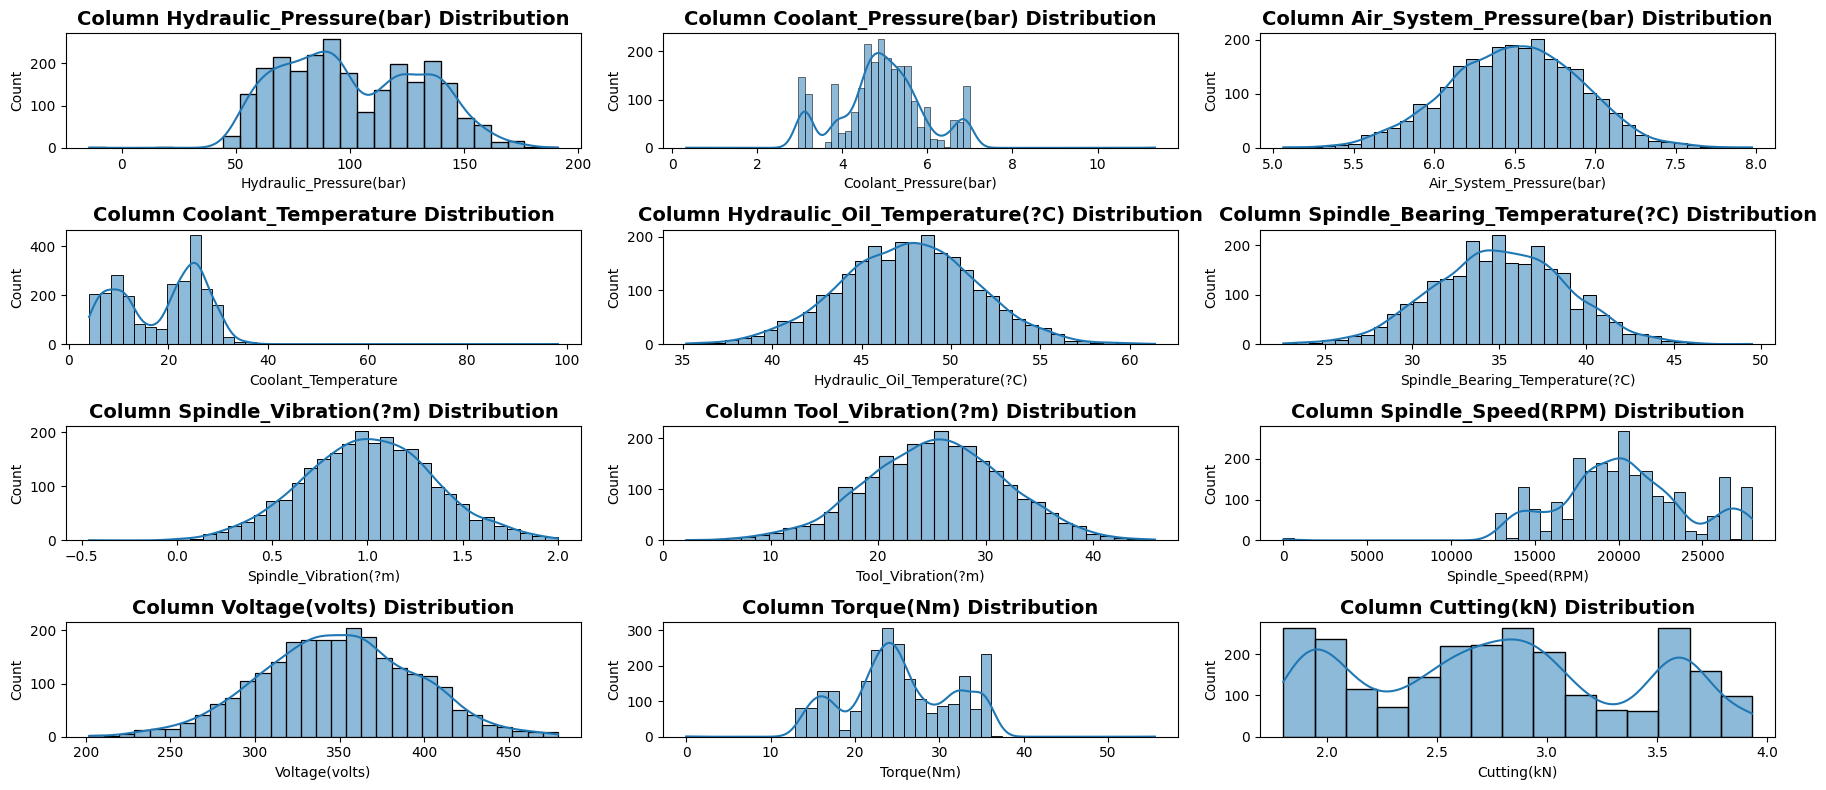

In [152]:
numeric = df.select_dtypes(include='number')

plt.figure(figsize=(18,8))
for i, col in enumerate(numeric.columns):
  plt.subplot(4, 3, i+1)
  sns.histplot(df[col], kde=True)
  plt.title(f'Column {col} Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

###b. Categorical Data

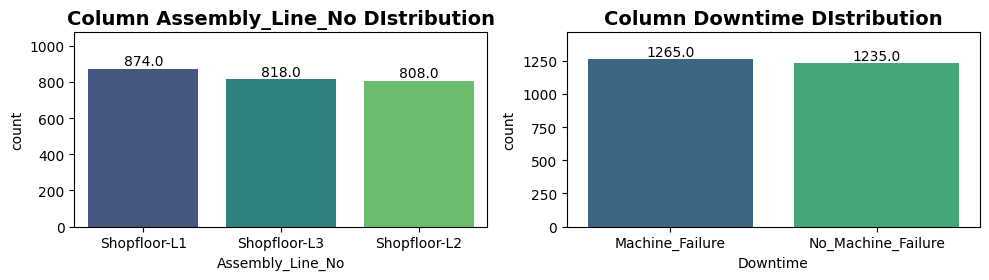

In [153]:
data = ['Assembly_Line_No', 'Downtime']

plt.figure(figsize=(10, 5))
for i, col in enumerate(data):
  plt.subplot(2, 2, i+1)
  counts = df[col].value_counts()
  ax = sns.countplot(x=df[col], hue=df[col], palette='viridis')
  for val in ax.containers:
    label=[v.get_height() for v in val]
    ax.bar_label(val, labels=label, label_type='edge')
  #ax.bar_label(ax.containers[0])
  plt.title(f'Column {col} DIstribution', fontsize=14, fontweight='bold')
  plt.ylim(ymax=counts.max() + 200)
plt.tight_layout()
plt.show()

In [154]:
cross_tab = pd.crosstab(df['Machine_ID'], df['Downtime'])
cross_tab

Downtime,Machine_Failure,No_Machine_Failure
Machine_ID,,
Makino-L1-Unit1-2013,454,420
Makino-L2-Unit1-2015,396,412
Makino-L3-Unit1-2015,415,403


In [155]:
df_failures_agg = df.groupby(by='Downtime').agg({
    'Hydraulic_Pressure(bar)': 'mean',
    'Coolant_Pressure(bar)': 'mean',
    'Air_System_Pressure(bar)': 'mean',
    'Coolant_Temperature': 'mean',
    'Hydraulic_Oil_Temperature(?C)': 'mean',
    'Spindle_Bearing_Temperature(?C)': 'mean',
    'Spindle_Vibration(?m)': 'mean',
    'Tool_Vibration(?m)': 'mean',
    'Spindle_Speed(RPM)': 'mean',
    'Voltage(volts)': 'mean',
    'Torque(Nm)': 'mean',
    'Cutting(kN)': 'mean',
})
df_failures_agg

,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN)
Downtime,,,,,,,,,,,,
Machine_Failure,84.760498,5.114900,6.502980,19.983083,47.571349,34.991370,1.003696,25.374516,21319.361265,349.258498,22.760998,3.056413
No_Machine_Failure,118.573694,4.772454,6.495476,17.087817,47.666667,35.137967,1.015124,25.450317,19199.625712,348.727421,27.775692,2.501341


##**6. Outlier Detection**
---

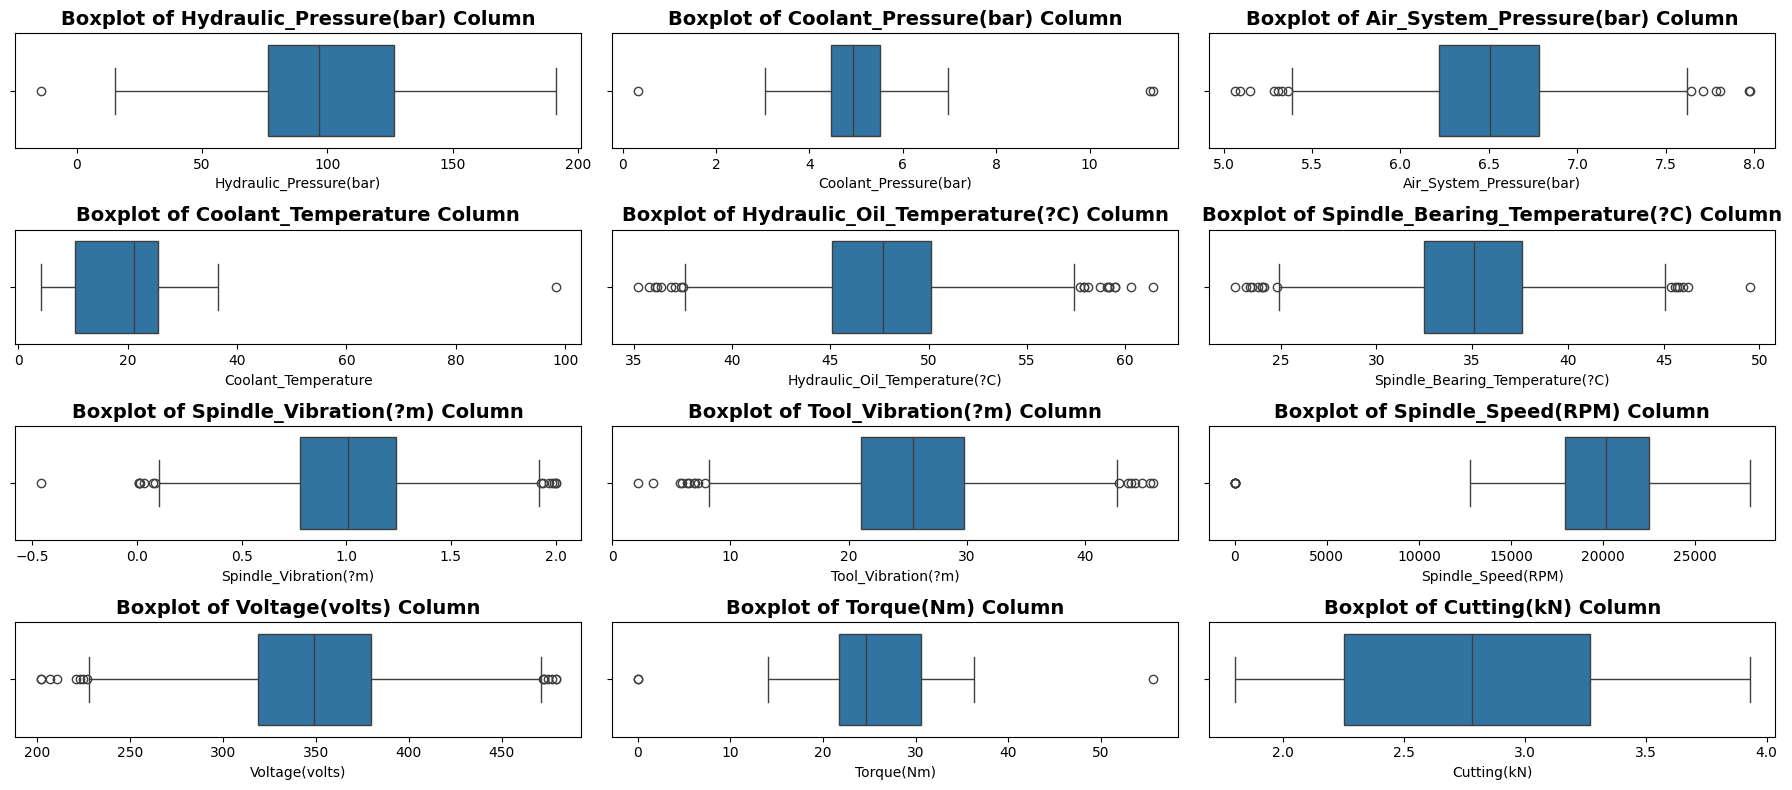

In [156]:
numeric = df.select_dtypes(include='number')

plt.figure(figsize=(18, 8))
for i, col in enumerate(numeric.columns):
  plt.subplot(4, 3, i+1)
  sns.boxplot(x=df[col])
  plt.title(f'Boxplot of {col} Column', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

##**7. Correlation Analysis**
---

In [157]:
#sns.pairplot(df)
#plt.show()

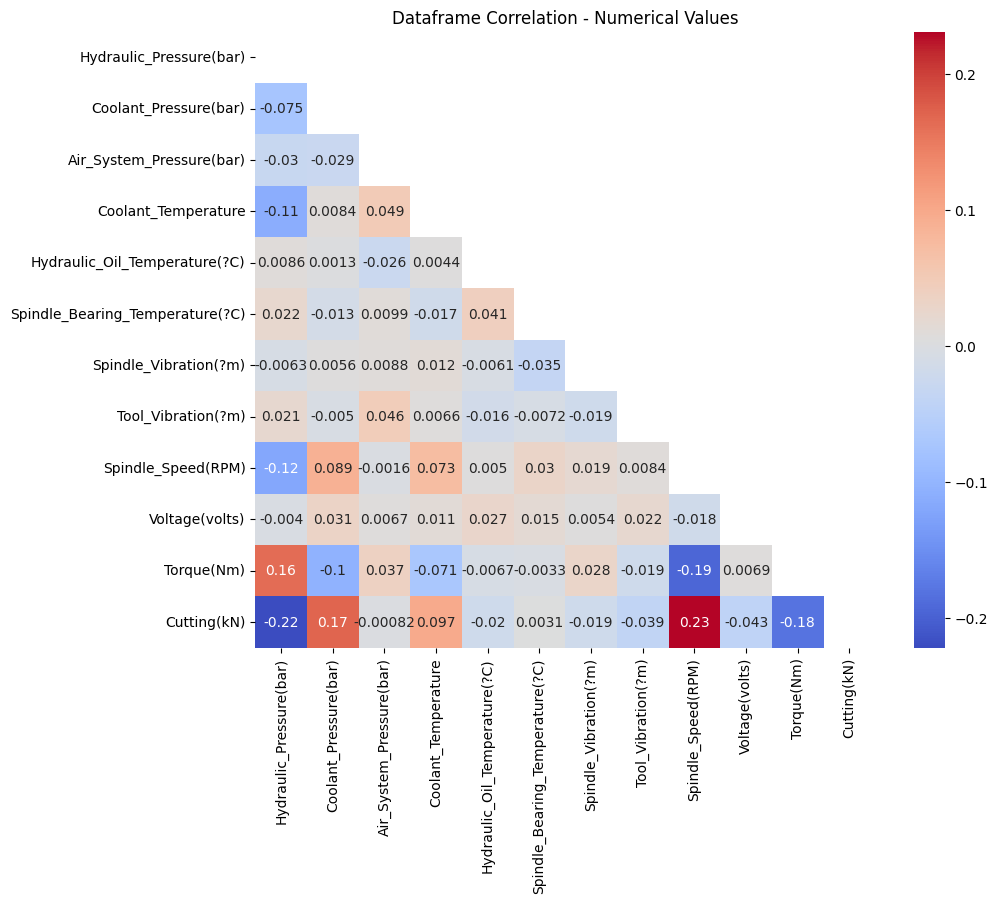

In [158]:
corr = df.select_dtypes(include='number').corr()
mask = np.triu(np.ones_like(corr, dtype=float))

plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm')
plt.title('Dataframe Correlation - Numerical Values')
plt.show()

#**Data Cleaning**
---

##**1. Outlier Handling**
---
The number of outlier is relatively insignificant, and upon further observation, it could be said that whilst far from the rest of the values in this dataset, most of the outliers do hold value and could be classed as genuine observations, except for columns:
1. Hydraulic_Pressure(bar) - observations of pressures under 0
2. Spindle_Vibration(?m) - observations of vibrations less than 0

In [159]:
numeric = df.select_dtypes(include='number')
outlier_idx = []

for col in numeric.columns:
  q3 = df[col].quantile(0.75)
  q1 = df[col].quantile(0.25)
  iqr = q3-q1

  df_outlier = np.where((df[col] < q1 - 1.5 * iqr) | (df[col] > q3 + 1.5 * iqr))[0].tolist()
  if len(df_outlier) > 0:
    outlier_pct = (len(df_outlier)/len(df)) * 100
    outlier_loc = df.loc[df_outlier, :]
    print(f'Percentage of outliers for column {col}: {outlier_pct}%')
    print(f'Number of outliers for column {col}: {len(df_outlier)}')
    display(outlier_loc)
    outlier_idx.extend(df_outlier)
    print(' ')

Percentage of outliers for column Hydraulic_Pressure(bar): 0.04%
Number of outliers for column Hydraulic_Pressure(bar): 1


,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
2058,06-02-2022,Makino-L3-Unit1-2015,Shopfloor-L3,-14.326454,5.067261,6.163999,6.8,49.6,39.2,1.627,17.723,20386.0,348.0,33.923365,2.73,No_Machine_Failure


 
Percentage of outliers for column Coolant_Pressure(bar): 0.12%
Number of outliers for column Coolant_Pressure(bar): 3


,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
851,20-03-2022,Makino-L3-Unit1-2015,Shopfloor-L3,140.916843,11.350,6.315380,5.7,49.3,30.4,1.468,26.444,15217.0,351.0,18.901770,1.87,No_Machine_Failure
853,20-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,112.341994,11.300,6.563934,34.1,44.2,38.9,1.407,32.362,25156.0,324.0,18.977659,2.01,No_Machine_Failure
913,19-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,74.890000,0.325,6.188361,22.0,50.0,24.1,0.923,31.222,21951.0,326.0,28.152023,2.41,Machine_Failure


 
Percentage of outliers for column Air_System_Pressure(bar): 0.52%
Number of outliers for column Air_System_Pressure(bar): 13


,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
125,29-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,55.150000,4.666802,5.091411,12.3,46.2,36.2,0.276,31.194,17919.0,388.0,17.899311,2.71,Machine_Failure
674,22-03-2022,Makino-L3-Unit1-2015,Shopfloor-L3,88.920000,5.567857,5.063480,6.2,44.4,37.6,1.435,32.596,16874.0,309.0,28.292165,3.49,Machine_Failure
739,21-04-2022,Makino-L1-Unit1-2013,Shopfloor-L1,96.950000,6.560332,7.971607,4.9,51.3,35.5,0.724,24.128,20801.0,340.0,16.449554,3.33,Machine_Failure
800,21-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,82.850000,4.870609,7.804750,24.4,42.9,29.2,0.989,30.032,19647.0,385.0,24.298977,3.55,Machine_Failure
950,19-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,143.949430,3.895031,5.366875,32.6,46.2,33.3,0.727,29.687,14266.0,313.0,33.923365,1.88,No_Machine_Failure
1135,17-01-2022,Makino-L2-Unit1-2015,Shopfloor-L2,143.440135,5.080215,7.712441,21.1,49.4,26.5,1.118,26.676,20438.0,372.0,30.514008,1.91,No_Machine_Failure
1190,16-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,77.600000,4.747308,7.973992,30.3,53.7,31.4,1.357,23.315,19158.0,417.0,24.919198,2.54,Machine_Failure
1659,11-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,134.865176,5.690481,7.781151,26.7,49.8,41.0,0.760,35.040,17726.0,374.0,32.394315,1.88,No_Machine_Failure
1910,07-04-2022,Makino-L1-Unit1-2013,Shopfloor-L1,137.160517,3.126011,5.329777,20.2,53.1,40.3,1.121,31.120,20101.0,374.0,23.750162,1.85,No_Machine_Failure
2101,05-04-2022,Makino-L3-Unit1-2015,Shopfloor-L3,175.100000,4.692049,5.151876,28.7,51.4,29.0,1.536,29.388,23432.0,362.0,17.899311,3.58,Machine_Failure


 
Percentage of outliers for column Coolant_Temperature: 0.04%
Number of outliers for column Coolant_Temperature: 1


,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
1035,18-02-2022,Makino-L2-Unit1-2015,Shopfloor-L2,119.761152,NaN,6.641547,98.2,44.4,30.0,1.303,28.941,19197.0,346.0,30.514008,3.63,No_Machine_Failure


 
Percentage of outliers for column Hydraulic_Oil_Temperature(?C): 0.84%
Number of outliers for column Hydraulic_Oil_Temperature(?C): 21


,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
127,29-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,91.920000,4.632908,6.770093,18.8,37.1,37.6,0.967,26.864,21951.0,358.0,16.449554,3.69,Machine_Failure
337,26-03-2022,Makino-L3-Unit1-2015,Shopfloor-L3,71.490000,4.150410,7.028656,25.4,57.9,35.1,1.319,34.504,21951.0,354.0,28.686576,2.46,Machine_Failure
375,26-01-2022,Makino-L1-Unit1-2013,Shopfloor-L1,79.870000,4.768416,6.564726,24.4,36.4,33.6,0.939,29.835,19251.0,370.0,24.798816,2.48,Machine_Failure
534,24-02-2022,Makino-L3-Unit1-2015,Shopfloor-L3,76.840000,4.807144,6.087880,26.4,59.5,43.5,0.709,24.568,19380.0,363.0,24.633746,2.83,Machine_Failure
588,23-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,103.203781,5.663439,6.314902,26.4,61.4,41.9,0.916,20.255,22653.0,378.0,31.620335,2.02,No_Machine_Failure
597,23-02-2022,Makino-L2-Unit1-2015,Shopfloor-L2,84.600000,4.754858,6.809208,12.4,37.4,30.3,0.999,20.143,26526.0,280.0,24.888020,3.67,Machine_Failure
614,23-02-2022,Makino-L3-Unit1-2015,Shopfloor-L3,76.430000,6.108823,6.748728,14.2,59.2,36.5,1.321,28.080,27957.0,320.0,24.903599,2.53,Machine_Failure
724,22-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,131.377070,5.375713,6.379810,23.9,36.9,37.6,0.753,26.670,21580.0,309.0,22.122428,2.91,No_Machine_Failure
825,20-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,55.490000,3.822990,6.019990,24.2,35.2,30.8,1.717,26.188,17919.0,310.0,31.538746,2.17,Machine_Failure
1002,18-03-2022,Makino-L3-Unit1-2015,Shopfloor-L3,119.761152,3.866647,6.398835,6.8,60.3,36.2,1.141,27.403,18436.0,318.0,32.370456,1.99,No_Machine_Failure


 
Percentage of outliers for column Spindle_Bearing_Temperature(?C): 0.64%
Number of outliers for column Spindle_Bearing_Temperature(?C): 16


,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
207,28-02-2022,Makino-L3-Unit1-2015,Shopfloor-L3,157.470000,4.842521,6.214942,16.6,49.5,46.3,0.873,26.210,21951.0,316.0,24.055326,2.93,Machine_Failure
271,27-03-2022,Makino-L3-Unit1-2015,Shopfloor-L3,98.136137,5.754695,5.972926,27.3,44.1,24.8,1.240,31.913,23040.0,361.0,20.720573,3.19,No_Machine_Failure
326,26-04-2022,Makino-L1-Unit1-2013,Shopfloor-L1,55.580000,6.560332,7.025107,26.3,44.1,45.7,1.072,29.714,27613.0,387.0,25.693020,3.69,Machine_Failure
692,22-03-2022,Makino-L3-Unit1-2015,Shopfloor-L3,103.610482,3.053451,6.223366,NaN,50.6,45.4,0.422,34.076,NaN,353.0,NaN,3.09,No_Machine_Failure
749,21-03-2022,Makino-L3-Unit1-2015,Shopfloor-L3,54.110000,4.205222,6.533211,9.5,49.3,23.8,0.782,22.207,26605.0,308.0,28.332463,2.27,Machine_Failure
913,19-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,74.890000,0.325000,6.188361,22.0,50.0,24.1,0.923,31.222,21951.0,326.0,28.152023,2.41,Machine_Failure
1139,16-05-2022,Makino-L3-Unit1-2015,Shopfloor-L3,83.080000,4.580476,6.967770,15.5,54.0,49.5,0.789,32.982,18487.0,358.0,25.823660,3.67,Machine_Failure
1355,14-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,97.740000,4.381427,6.598134,24.4,49.6,23.2,0.822,17.750,26605.0,330.0,27.154428,3.49,Machine_Failure
1693,10-04-2022,Makino-L2-Unit1-2015,Shopfloor-L2,85.736630,5.230446,6.803638,22.5,40.4,22.6,0.818,21.602,16198.0,350.0,22.712879,2.88,No_Machine_Failure
1913,07-04-2022,Makino-L1-Unit1-2013,Shopfloor-L1,98.700000,4.708917,6.554475,16.7,47.0,45.8,0.575,37.669,26605.0,320.0,15.119739,2.49,Machine_Failure


 
Percentage of outliers for column Spindle_Vibration(?m): 0.6%
Number of outliers for column Spindle_Vibration(?m): 15


,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
75,30-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,72.190000,4.631964,7.228819,29.8,43.7,40.2,2.000,30.001,18677.0,303.0,15.119739,3.91,Machine_Failure
99,30-01-2022,Makino-L3-Unit1-2015,Shopfloor-L3,117.122660,3.895031,6.506133,4.5,45.6,31.6,0.010,27.377,16198.0,313.0,22.808370,1.91,No_Machine_Failure
222,28-02-2022,Makino-L2-Unit1-2015,Shopfloor-L2,122.028791,5.537401,5.799850,8.7,51.1,35.9,-0.461,16.647,19197.0,349.0,21.533694,2.85,No_Machine_Failure
351,26-02-2022,Makino-L2-Unit1-2015,Shopfloor-L2,82.340000,4.945748,6.829641,24.4,44.3,36.6,1.984,18.042,19891.0,319.0,24.000905,2.72,Machine_Failure
796,21-02-2022,Makino-L3-Unit1-2015,Shopfloor-L3,141.368175,5.918941,6.549037,10.6,43.9,38.0,0.076,22.473,14152.0,403.0,20.259803,3.07,No_Machine_Failure
1217,15-04-2022,Makino-L1-Unit1-2013,Shopfloor-L1,112.155270,5.263304,6.998291,22.8,51.3,37.9,0.010,31.928,21154.0,308.0,32.370456,2.17,No_Machine_Failure
1252,15-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,83.700000,3.925254,6.428049,30.3,43.8,30.5,0.088,16.012,15512.0,422.0,30.776302,2.38,Machine_Failure
1414,13-04-2022,Makino-L2-Unit1-2015,Shopfloor-L2,99.100000,4.543077,6.291986,11.5,46.5,28.2,1.929,32.384,18316.0,364.0,26.064752,2.60,Machine_Failure
1662,11-01-2022,Makino-L3-Unit1-2015,Shopfloor-L3,161.851281,5.161441,6.301069,4.5,47.7,37.4,1.994,25.405,20764.0,342.0,22.991813,NaN,No_Machine_Failure
1670,10-05-2022,Makino-L1-Unit1-2013,Shopfloor-L1,134.540000,6.560332,6.198635,13.7,49.9,34.0,0.033,20.702,18387.0,404.0,16.964105,3.61,Machine_Failure


 
Percentage of outliers for column Tool_Vibration(?m): 0.6799999999999999%
Number of outliers for column Tool_Vibration(?m): 17


,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
63,30-03-2022,Makino-L3-Unit1-2015,Shopfloor-L3,132.821406,3.126011,6.690248,5.7,44.7,34.6,1.006,43.624,17726.0,272.0,23.833159,2.01,No_Machine_Failure
111,29-04-2022,Makino-L2-Unit1-2015,Shopfloor-L2,92.380000,4.609862,7.005160,16.8,45.4,40.7,1.339,42.901,21951.0,342.0,14.202890,3.61,Machine_Failure
361,26-02-2022,Makino-L3-Unit1-2015,Shopfloor-L3,131.134322,3.888835,6.951270,23.4,NaN,31.4,1.079,2.161,21423.0,320.0,22.284554,2.17,No_Machine_Failure
493,24-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,141.140000,4.113430,6.582796,8.1,41.3,35.5,0.997,43.893,16541.0,366.0,28.861738,2.22,Machine_Failure
845,20-03-2022,Makino-L3-Unit1-2015,Shopfloor-L3,124.470038,6.249545,7.101710,31.3,42.9,37.1,0.964,45.726,24616.0,286.0,19.393971,2.88,No_Machine_Failure
989,18-04-2022,Makino-L3-Unit1-2015,Shopfloor-L3,90.100000,4.508622,6.620184,28.7,51.3,26.6,1.070,6.539,18152.0,274.0,16.449554,3.61,Machine_Failure
1366,14-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,71.130000,3.982074,6.369743,26.4,44.4,32.3,0.528,5.892,21951.0,333.0,30.099111,2.43,Machine_Failure
1427,13-04-2022,Makino-L2-Unit1-2015,Shopfloor-L2,53.440000,4.539137,6.543853,4.1,51.6,35.7,1.119,5.775,20504.0,399.0,26.083265,2.51,Machine_Failure
1504,12-04-2022,Makino-L1-Unit1-2013,Shopfloor-L1,68.480000,4.544957,6.662468,10.5,49.8,36.1,0.860,6.338,22457.0,335.0,26.044845,3.55,Machine_Failure
1533,12-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,149.143030,5.302592,6.304178,23.2,47.5,33.6,1.170,6.977,14266.0,312.0,22.394315,1.88,No_Machine_Failure


 
Percentage of outliers for column Spindle_Speed(RPM): 0.27999999999999997%
Number of outliers for column Spindle_Speed(RPM): 7


,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
466,24-11-2021,Makino-L3-Unit1-2015,Shopfloor-L3,88.64,6.560332,6.210167,6.1,44.4,36.8,0.815,24.067,0.0,328.0,29.005529,2.26,Machine_Failure
929,19-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,99.81,6.863944,6.462017,29.8,48.3,38.0,1.267,19.736,0.0,409.0,16.449554,3.59,Machine_Failure
938,19-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,52.96,5.918357,7.275132,5.1,53.2,31.9,0.859,31.685,0.0,301.0,22.433250,2.92,Machine_Failure
951,19-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,54.04,4.566854,5.581496,24.2,44.5,33.6,0.957,26.329,0.0,322.0,20.423615,3.13,Machine_Failure
952,19-03-2022,Makino-L3-Unit1-2015,Shopfloor-L3,70.22,5.567857,6.484372,7.8,51.8,34.2,0.963,28.207,0.0,361.0,22.474437,2.94,Machine_Failure
953,19-03-2022,Makino-L3-Unit1-2015,Shopfloor-L3,73.85,6.560332,6.412568,32.8,52.8,33.2,0.891,35.373,0.0,393.0,23.157992,2.94,Machine_Failure
1012,18-03-2022,Makino-L3-Unit1-2015,Shopfloor-L3,84.79,3.598776,7.188335,11.5,50.1,35.3,0.744,23.441,0.0,338.0,25.154223,2.57,Machine_Failure


 
Percentage of outliers for column Voltage(volts): 0.6%
Number of outliers for column Voltage(volts): 15


,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
81,30-03-2022,Makino-L3-Unit1-2015,Shopfloor-L3,95.290000,4.631763,6.465048,24.4,44.9,31.6,0.791,28.124,18676.0,223.0,15.900716,2.53,Machine_Failure
221,28-02-2022,Makino-L3-Unit1-2015,Shopfloor-L3,124.692315,5.447690,6.129839,9.9,42.6,29.8,0.828,27.852,13272.0,227.0,29.869079,3.00,No_Machine_Failure
460,25-01-2022,Makino-L2-Unit1-2015,Shopfloor-L2,105.090135,3.053451,6.455772,22.6,49.6,39.5,1.246,15.139,21057.0,473.0,22.671891,2.97,No_Machine_Failure
491,24-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,134.451964,5.593650,5.696312,25.9,43.4,31.5,1.346,20.061,22405.0,211.0,33.355120,3.17,No_Machine_Failure
511,24-02-2022,Makino-L2-Unit1-2015,Shopfloor-L2,114.459585,3.053149,5.601535,5.7,41.7,32.6,1.036,22.288,21294.0,477.0,34.973004,3.06,No_Machine_Failure
709,22-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,129.738325,3.053149,5.667466,23.9,50.7,34.0,0.639,26.724,21576.0,221.0,33.355120,3.03,No_Machine_Failure
830,20-03-2022,Makino-L3-Unit1-2015,Shopfloor-L3,81.240000,6.863944,5.456959,21.1,51.3,32.1,0.869,25.332,20504.0,202.0,28.235273,3.59,Machine_Failure
991,18-04-2022,Makino-L1-Unit1-2013,Shopfloor-L1,71.890000,4.842521,5.997110,29.8,45.4,35.7,0.366,24.855,18152.0,202.0,14.447050,3.67,Machine_Failure
1204,16-01-2022,Makino-L2-Unit1-2015,Shopfloor-L2,149.022364,3.053149,5.923010,5.7,NaN,41.8,1.197,24.494,19197.0,475.0,23.369982,2.87,No_Machine_Failure
1399,14-01-2022,Makino-L1-Unit1-2013,Shopfloor-L1,92.855740,5.077498,6.780751,21.1,40.5,33.5,0.843,22.864,20424.0,479.0,34.973004,1.95,No_Machine_Failure


 
Percentage of outliers for column Torque(Nm): 0.12%
Number of outliers for column Torque(Nm): 3


,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
478,24-04-2022,Makino-L1-Unit1-2013,Shopfloor-L1,134.540000,6.893182,6.649668,8.0,48.3,32.9,0.470,36.048,21951.0,334.0,0.0000,3.67,Machine_Failure
879,20-02-2022,Makino-L3-Unit1-2015,Shopfloor-L3,123.132833,5.820914,6.993879,5.7,48.3,31.6,1.422,16.827,23275.0,352.0,55.5524,3.29,No_Machine_Failure
2000,06-04-2022,Makino-L2-Unit1-2015,Shopfloor-L2,72.466020,5.004733,6.985822,10.6,50.1,29.8,0.413,32.541,20112.0,354.0,0.0000,2.02,No_Machine_Failure


In [160]:
outlier_idx = list(set(outlier_idx))
print(f'Number of rows with outliers: {len(outlier_idx)}')
print(f'Percentage of rows with outliers: {(len(outlier_idx) / len(df)) * 100}%')

Number of rows with outliers: 111
Percentage of rows with outliers: 4.44%


###Deleting extreme values
---
On columns:
1. Hydraulic_Pressure(bar) - observations of pressures under 0
2. Spindle_Vibration(?m) - observations of vibrations less than 0

In [161]:
idx_to_delete = []

idx_hydraulic_ext = df[df['Hydraulic_Pressure(bar)'] < 0].index.tolist()
idx_to_delete.extend(idx_hydraulic_ext)
idx_spindle_ext = df[df['Spindle_Vibration(?m)'] < 0].index.tolist()
idx_to_delete.extend(idx_spindle_ext)

df = df.drop(idx_to_delete)
df = df.reset_index(drop=True)
df.head()

,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
0,31-12-2021,Makino-L1-Unit1-2013,Shopfloor-L1,71.04,6.933725,6.284965,25.6,46.0,33.4,1.291,26.492,25892.0,335.0,24.055326,3.58,Machine_Failure
1,31-12-2021,Makino-L1-Unit1-2013,Shopfloor-L1,125.33,4.936892,6.196733,35.3,47.4,34.6,1.382,25.274,19856.0,368.0,14.202890,2.68,Machine_Failure
2,31-12-2021,Makino-L3-Unit1-2015,Shopfloor-L3,71.12,6.839413,6.655448,13.1,40.7,33.0,1.319,30.608,19851.0,325.0,24.049267,3.55,Machine_Failure
3,31-05-2022,Makino-L2-Unit1-2015,Shopfloor-L2,139.34,4.574382,6.560394,24.4,44.2,40.6,0.618,30.791,18461.0,360.0,25.860029,3.55,Machine_Failure
4,31-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,60.51,6.893182,6.141238,4.1,47.3,31.4,0.983,25.516,26526.0,354.0,25.515874,3.55,Machine_Failure


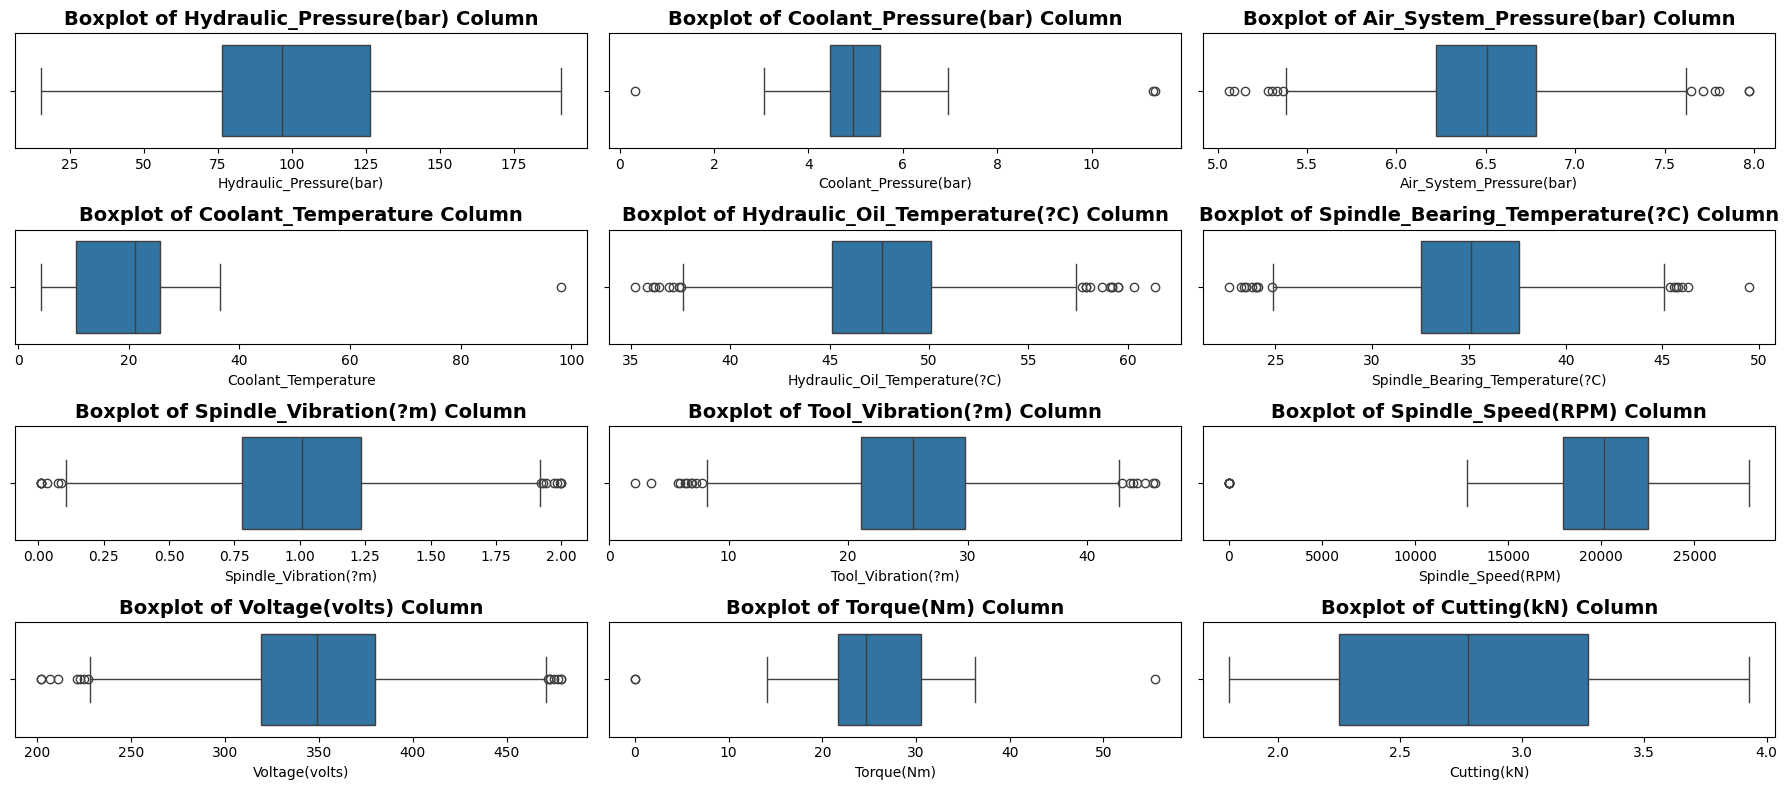

In [162]:
numeric = df.select_dtypes(include='number')

plt.figure(figsize=(18, 8))
for i, col in enumerate(numeric.columns):
  plt.subplot(4, 3, i+1)
  sns.boxplot(x=df[col])
  plt.title(f'Boxplot of {col} Column', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

##**2. Missing Data Handling**
---
Since the missing values are only a small percentage (<6%) of the entire dataset, it is decided that the missing data would be replaced with values of central tendencies for the corresponding column
1. Hydraulic_Pressure(bar) - mean
2. Coolant_Pressure(bar) - mean
3. Air_System_Pressure(bar) - mean
4. Coolant_Temperature - median
5. Hydraulic_Oil_Temperature(?C) - mean
6. Spindle_Bearing_Temperature(?C) - mean
7. Spindle_Vibration(?m) - mean
8. Tool_Vibration(?m) - mean
9. Spindle_Speed(RPM) - mean
10. Voltage(volts) - mean
11. Torque(Nm) - mean
12. Cutting(kN) - mean

In [163]:
df.isnull().sum()

,0
Date,0
Machine_ID,0
Assembly_Line_No,0
Hydraulic_Pressure(bar),10
Coolant_Pressure(bar),19
Air_System_Pressure(bar),17
Coolant_Temperature,12
Hydraulic_Oil_Temperature(?C),16
Spindle_Bearing_Temperature(?C),7
Spindle_Vibration(?m),11


In [164]:
missing_values = df.isnull().sum().sum()
missing_values_pct = (missing_values/len(df)) * 100
print(f'Missing values sum: {missing_values}')
print(f'Percentage of missing values: {missing_values_pct}%')

Missing values sum: 143
Percentage of missing values: 5.724579663730984%


In [165]:
for col in df.columns:
  if df[col].isnull().sum() > 0:
    missing_num = int(df[col].isnull().sum())
    print(f'Percentage of missing value on {col} column: {(missing_num/len(df)) * 100}%')
    df_missing = df[df.isnull().any(axis=1)]
    display(df_missing)
    print(' ')

Percentage of missing value on Hydraulic_Pressure(bar) column: 0.4003202562049639%


,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
128,29-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,134.981845,5.674679,6.655508,26.5,51.7,35.3,0.908,NaN,22734.0,352.0,20.999472,2.88,No_Machine_Failure
155,28-12-2021,Makino-L1-Unit1-2013,Shopfloor-L1,112.430664,5.128736,NaN,21.6,40.5,31.4,1.075,28.592,20624.0,340.0,23.147886,1.89,No_Machine_Failure
213,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,123.492670,5.563162,6.265352,12.2,NaN,40.3,0.415,NaN,14266.0,321.0,21.412002,3.02,No_Machine_Failure
216,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,137.617864,5.544234,NaN,25.5,48.2,35.4,0.767,23.723,14266.0,320.0,32.370456,1.99,No_Machine_Failure
265,27-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,77.200000,4.650913,7.119539,22.6,43.0,35.1,0.839,26.218,18784.0,404.0,NaN,2.57,Machine_Failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2446,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,95.714928,3.888835,NaN,4.5,NaN,34.5,0.758,38.343,22032.0,281.0,21.668573,3.16,No_Machine_Failure
2451,01-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,127.951375,NaN,6.387363,24.6,35.8,34.8,1.774,25.390,21880.0,382.0,31.620335,1.87,No_Machine_Failure
2456,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,113.021660,3.888835,6.463824,24.8,49.3,36.5,0.182,NaN,21981.0,360.0,31.521075,1.88,No_Machine_Failure
2459,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,NaN,5.425502,6.155373,24.3,50.1,33.8,0.849,27.087,17726.0,351.0,21.975787,1.91,No_Machine_Failure


 
Percentage of missing value on Coolant_Pressure(bar) column: 0.7606084867894315%


,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
128,29-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,134.981845,5.674679,6.655508,26.5,51.7,35.3,0.908,NaN,22734.0,352.0,20.999472,2.88,No_Machine_Failure
155,28-12-2021,Makino-L1-Unit1-2013,Shopfloor-L1,112.430664,5.128736,NaN,21.6,40.5,31.4,1.075,28.592,20624.0,340.0,23.147886,1.89,No_Machine_Failure
213,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,123.492670,5.563162,6.265352,12.2,NaN,40.3,0.415,NaN,14266.0,321.0,21.412002,3.02,No_Machine_Failure
216,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,137.617864,5.544234,NaN,25.5,48.2,35.4,0.767,23.723,14266.0,320.0,32.370456,1.99,No_Machine_Failure
265,27-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,77.200000,4.650913,7.119539,22.6,43.0,35.1,0.839,26.218,18784.0,404.0,NaN,2.57,Machine_Failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2446,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,95.714928,3.888835,NaN,4.5,NaN,34.5,0.758,38.343,22032.0,281.0,21.668573,3.16,No_Machine_Failure
2451,01-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,127.951375,NaN,6.387363,24.6,35.8,34.8,1.774,25.390,21880.0,382.0,31.620335,1.87,No_Machine_Failure
2456,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,113.021660,3.888835,6.463824,24.8,49.3,36.5,0.182,NaN,21981.0,360.0,31.521075,1.88,No_Machine_Failure
2459,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,NaN,5.425502,6.155373,24.3,50.1,33.8,0.849,27.087,17726.0,351.0,21.975787,1.91,No_Machine_Failure


 
Percentage of missing value on Air_System_Pressure(bar) column: 0.6805444355484388%


,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
128,29-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,134.981845,5.674679,6.655508,26.5,51.7,35.3,0.908,NaN,22734.0,352.0,20.999472,2.88,No_Machine_Failure
155,28-12-2021,Makino-L1-Unit1-2013,Shopfloor-L1,112.430664,5.128736,NaN,21.6,40.5,31.4,1.075,28.592,20624.0,340.0,23.147886,1.89,No_Machine_Failure
213,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,123.492670,5.563162,6.265352,12.2,NaN,40.3,0.415,NaN,14266.0,321.0,21.412002,3.02,No_Machine_Failure
216,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,137.617864,5.544234,NaN,25.5,48.2,35.4,0.767,23.723,14266.0,320.0,32.370456,1.99,No_Machine_Failure
265,27-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,77.200000,4.650913,7.119539,22.6,43.0,35.1,0.839,26.218,18784.0,404.0,NaN,2.57,Machine_Failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2446,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,95.714928,3.888835,NaN,4.5,NaN,34.5,0.758,38.343,22032.0,281.0,21.668573,3.16,No_Machine_Failure
2451,01-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,127.951375,NaN,6.387363,24.6,35.8,34.8,1.774,25.390,21880.0,382.0,31.620335,1.87,No_Machine_Failure
2456,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,113.021660,3.888835,6.463824,24.8,49.3,36.5,0.182,NaN,21981.0,360.0,31.521075,1.88,No_Machine_Failure
2459,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,NaN,5.425502,6.155373,24.3,50.1,33.8,0.849,27.087,17726.0,351.0,21.975787,1.91,No_Machine_Failure


 
Percentage of missing value on Coolant_Temperature column: 0.4803843074459567%


,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
128,29-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,134.981845,5.674679,6.655508,26.5,51.7,35.3,0.908,NaN,22734.0,352.0,20.999472,2.88,No_Machine_Failure
155,28-12-2021,Makino-L1-Unit1-2013,Shopfloor-L1,112.430664,5.128736,NaN,21.6,40.5,31.4,1.075,28.592,20624.0,340.0,23.147886,1.89,No_Machine_Failure
213,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,123.492670,5.563162,6.265352,12.2,NaN,40.3,0.415,NaN,14266.0,321.0,21.412002,3.02,No_Machine_Failure
216,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,137.617864,5.544234,NaN,25.5,48.2,35.4,0.767,23.723,14266.0,320.0,32.370456,1.99,No_Machine_Failure
265,27-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,77.200000,4.650913,7.119539,22.6,43.0,35.1,0.839,26.218,18784.0,404.0,NaN,2.57,Machine_Failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2446,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,95.714928,3.888835,NaN,4.5,NaN,34.5,0.758,38.343,22032.0,281.0,21.668573,3.16,No_Machine_Failure
2451,01-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,127.951375,NaN,6.387363,24.6,35.8,34.8,1.774,25.390,21880.0,382.0,31.620335,1.87,No_Machine_Failure
2456,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,113.021660,3.888835,6.463824,24.8,49.3,36.5,0.182,NaN,21981.0,360.0,31.521075,1.88,No_Machine_Failure
2459,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,NaN,5.425502,6.155373,24.3,50.1,33.8,0.849,27.087,17726.0,351.0,21.975787,1.91,No_Machine_Failure


 
Percentage of missing value on Hydraulic_Oil_Temperature(?C) column: 0.6405124099279423%


,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
128,29-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,134.981845,5.674679,6.655508,26.5,51.7,35.3,0.908,NaN,22734.0,352.0,20.999472,2.88,No_Machine_Failure
155,28-12-2021,Makino-L1-Unit1-2013,Shopfloor-L1,112.430664,5.128736,NaN,21.6,40.5,31.4,1.075,28.592,20624.0,340.0,23.147886,1.89,No_Machine_Failure
213,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,123.492670,5.563162,6.265352,12.2,NaN,40.3,0.415,NaN,14266.0,321.0,21.412002,3.02,No_Machine_Failure
216,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,137.617864,5.544234,NaN,25.5,48.2,35.4,0.767,23.723,14266.0,320.0,32.370456,1.99,No_Machine_Failure
265,27-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,77.200000,4.650913,7.119539,22.6,43.0,35.1,0.839,26.218,18784.0,404.0,NaN,2.57,Machine_Failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2446,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,95.714928,3.888835,NaN,4.5,NaN,34.5,0.758,38.343,22032.0,281.0,21.668573,3.16,No_Machine_Failure
2451,01-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,127.951375,NaN,6.387363,24.6,35.8,34.8,1.774,25.390,21880.0,382.0,31.620335,1.87,No_Machine_Failure
2456,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,113.021660,3.888835,6.463824,24.8,49.3,36.5,0.182,NaN,21981.0,360.0,31.521075,1.88,No_Machine_Failure
2459,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,NaN,5.425502,6.155373,24.3,50.1,33.8,0.849,27.087,17726.0,351.0,21.975787,1.91,No_Machine_Failure


 
Percentage of missing value on Spindle_Bearing_Temperature(?C) column: 0.28022417934347477%


,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
128,29-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,134.981845,5.674679,6.655508,26.5,51.7,35.3,0.908,NaN,22734.0,352.0,20.999472,2.88,No_Machine_Failure
155,28-12-2021,Makino-L1-Unit1-2013,Shopfloor-L1,112.430664,5.128736,NaN,21.6,40.5,31.4,1.075,28.592,20624.0,340.0,23.147886,1.89,No_Machine_Failure
213,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,123.492670,5.563162,6.265352,12.2,NaN,40.3,0.415,NaN,14266.0,321.0,21.412002,3.02,No_Machine_Failure
216,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,137.617864,5.544234,NaN,25.5,48.2,35.4,0.767,23.723,14266.0,320.0,32.370456,1.99,No_Machine_Failure
265,27-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,77.200000,4.650913,7.119539,22.6,43.0,35.1,0.839,26.218,18784.0,404.0,NaN,2.57,Machine_Failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2446,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,95.714928,3.888835,NaN,4.5,NaN,34.5,0.758,38.343,22032.0,281.0,21.668573,3.16,No_Machine_Failure
2451,01-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,127.951375,NaN,6.387363,24.6,35.8,34.8,1.774,25.390,21880.0,382.0,31.620335,1.87,No_Machine_Failure
2456,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,113.021660,3.888835,6.463824,24.8,49.3,36.5,0.182,NaN,21981.0,360.0,31.521075,1.88,No_Machine_Failure
2459,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,NaN,5.425502,6.155373,24.3,50.1,33.8,0.849,27.087,17726.0,351.0,21.975787,1.91,No_Machine_Failure


 
Percentage of missing value on Spindle_Vibration(?m) column: 0.4403522818254604%


,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
128,29-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,134.981845,5.674679,6.655508,26.5,51.7,35.3,0.908,NaN,22734.0,352.0,20.999472,2.88,No_Machine_Failure
155,28-12-2021,Makino-L1-Unit1-2013,Shopfloor-L1,112.430664,5.128736,NaN,21.6,40.5,31.4,1.075,28.592,20624.0,340.0,23.147886,1.89,No_Machine_Failure
213,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,123.492670,5.563162,6.265352,12.2,NaN,40.3,0.415,NaN,14266.0,321.0,21.412002,3.02,No_Machine_Failure
216,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,137.617864,5.544234,NaN,25.5,48.2,35.4,0.767,23.723,14266.0,320.0,32.370456,1.99,No_Machine_Failure
265,27-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,77.200000,4.650913,7.119539,22.6,43.0,35.1,0.839,26.218,18784.0,404.0,NaN,2.57,Machine_Failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2446,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,95.714928,3.888835,NaN,4.5,NaN,34.5,0.758,38.343,22032.0,281.0,21.668573,3.16,No_Machine_Failure
2451,01-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,127.951375,NaN,6.387363,24.6,35.8,34.8,1.774,25.390,21880.0,382.0,31.620335,1.87,No_Machine_Failure
2456,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,113.021660,3.888835,6.463824,24.8,49.3,36.5,0.182,NaN,21981.0,360.0,31.521075,1.88,No_Machine_Failure
2459,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,NaN,5.425502,6.155373,24.3,50.1,33.8,0.849,27.087,17726.0,351.0,21.975787,1.91,No_Machine_Failure


 
Percentage of missing value on Tool_Vibration(?m) column: 0.4403522818254604%


,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
128,29-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,134.981845,5.674679,6.655508,26.5,51.7,35.3,0.908,NaN,22734.0,352.0,20.999472,2.88,No_Machine_Failure
155,28-12-2021,Makino-L1-Unit1-2013,Shopfloor-L1,112.430664,5.128736,NaN,21.6,40.5,31.4,1.075,28.592,20624.0,340.0,23.147886,1.89,No_Machine_Failure
213,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,123.492670,5.563162,6.265352,12.2,NaN,40.3,0.415,NaN,14266.0,321.0,21.412002,3.02,No_Machine_Failure
216,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,137.617864,5.544234,NaN,25.5,48.2,35.4,0.767,23.723,14266.0,320.0,32.370456,1.99,No_Machine_Failure
265,27-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,77.200000,4.650913,7.119539,22.6,43.0,35.1,0.839,26.218,18784.0,404.0,NaN,2.57,Machine_Failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2446,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,95.714928,3.888835,NaN,4.5,NaN,34.5,0.758,38.343,22032.0,281.0,21.668573,3.16,No_Machine_Failure
2451,01-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,127.951375,NaN,6.387363,24.6,35.8,34.8,1.774,25.390,21880.0,382.0,31.620335,1.87,No_Machine_Failure
2456,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,113.021660,3.888835,6.463824,24.8,49.3,36.5,0.182,NaN,21981.0,360.0,31.521075,1.88,No_Machine_Failure
2459,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,NaN,5.425502,6.155373,24.3,50.1,33.8,0.849,27.087,17726.0,351.0,21.975787,1.91,No_Machine_Failure


 
Percentage of missing value on Spindle_Speed(RPM) column: 0.24019215372297836%


,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
128,29-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,134.981845,5.674679,6.655508,26.5,51.7,35.3,0.908,NaN,22734.0,352.0,20.999472,2.88,No_Machine_Failure
155,28-12-2021,Makino-L1-Unit1-2013,Shopfloor-L1,112.430664,5.128736,NaN,21.6,40.5,31.4,1.075,28.592,20624.0,340.0,23.147886,1.89,No_Machine_Failure
213,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,123.492670,5.563162,6.265352,12.2,NaN,40.3,0.415,NaN,14266.0,321.0,21.412002,3.02,No_Machine_Failure
216,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,137.617864,5.544234,NaN,25.5,48.2,35.4,0.767,23.723,14266.0,320.0,32.370456,1.99,No_Machine_Failure
265,27-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,77.200000,4.650913,7.119539,22.6,43.0,35.1,0.839,26.218,18784.0,404.0,NaN,2.57,Machine_Failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2446,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,95.714928,3.888835,NaN,4.5,NaN,34.5,0.758,38.343,22032.0,281.0,21.668573,3.16,No_Machine_Failure
2451,01-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,127.951375,NaN,6.387363,24.6,35.8,34.8,1.774,25.390,21880.0,382.0,31.620335,1.87,No_Machine_Failure
2456,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,113.021660,3.888835,6.463824,24.8,49.3,36.5,0.182,NaN,21981.0,360.0,31.521075,1.88,No_Machine_Failure
2459,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,NaN,5.425502,6.155373,24.3,50.1,33.8,0.849,27.087,17726.0,351.0,21.975787,1.91,No_Machine_Failure


 
Percentage of missing value on Voltage(volts) column: 0.24019215372297836%


,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
128,29-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,134.981845,5.674679,6.655508,26.5,51.7,35.3,0.908,NaN,22734.0,352.0,20.999472,2.88,No_Machine_Failure
155,28-12-2021,Makino-L1-Unit1-2013,Shopfloor-L1,112.430664,5.128736,NaN,21.6,40.5,31.4,1.075,28.592,20624.0,340.0,23.147886,1.89,No_Machine_Failure
213,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,123.492670,5.563162,6.265352,12.2,NaN,40.3,0.415,NaN,14266.0,321.0,21.412002,3.02,No_Machine_Failure
216,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,137.617864,5.544234,NaN,25.5,48.2,35.4,0.767,23.723,14266.0,320.0,32.370456,1.99,No_Machine_Failure
265,27-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,77.200000,4.650913,7.119539,22.6,43.0,35.1,0.839,26.218,18784.0,404.0,NaN,2.57,Machine_Failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2446,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,95.714928,3.888835,NaN,4.5,NaN,34.5,0.758,38.343,22032.0,281.0,21.668573,3.16,No_Machine_Failure
2451,01-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,127.951375,NaN,6.387363,24.6,35.8,34.8,1.774,25.390,21880.0,382.0,31.620335,1.87,No_Machine_Failure
2456,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,113.021660,3.888835,6.463824,24.8,49.3,36.5,0.182,NaN,21981.0,360.0,31.521075,1.88,No_Machine_Failure
2459,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,NaN,5.425502,6.155373,24.3,50.1,33.8,0.849,27.087,17726.0,351.0,21.975787,1.91,No_Machine_Failure


 
Percentage of missing value on Torque(Nm) column: 0.8406725380304243%


,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
128,29-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,134.981845,5.674679,6.655508,26.5,51.7,35.3,0.908,NaN,22734.0,352.0,20.999472,2.88,No_Machine_Failure
155,28-12-2021,Makino-L1-Unit1-2013,Shopfloor-L1,112.430664,5.128736,NaN,21.6,40.5,31.4,1.075,28.592,20624.0,340.0,23.147886,1.89,No_Machine_Failure
213,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,123.492670,5.563162,6.265352,12.2,NaN,40.3,0.415,NaN,14266.0,321.0,21.412002,3.02,No_Machine_Failure
216,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,137.617864,5.544234,NaN,25.5,48.2,35.4,0.767,23.723,14266.0,320.0,32.370456,1.99,No_Machine_Failure
265,27-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,77.200000,4.650913,7.119539,22.6,43.0,35.1,0.839,26.218,18784.0,404.0,NaN,2.57,Machine_Failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2446,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,95.714928,3.888835,NaN,4.5,NaN,34.5,0.758,38.343,22032.0,281.0,21.668573,3.16,No_Machine_Failure
2451,01-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,127.951375,NaN,6.387363,24.6,35.8,34.8,1.774,25.390,21880.0,382.0,31.620335,1.87,No_Machine_Failure
2456,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,113.021660,3.888835,6.463824,24.8,49.3,36.5,0.182,NaN,21981.0,360.0,31.521075,1.88,No_Machine_Failure
2459,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,NaN,5.425502,6.155373,24.3,50.1,33.8,0.849,27.087,17726.0,351.0,21.975787,1.91,No_Machine_Failure


 
Percentage of missing value on Cutting(kN) column: 0.28022417934347477%


,Date,Machine_ID,Assembly_Line_No,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime
128,29-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,134.981845,5.674679,6.655508,26.5,51.7,35.3,0.908,NaN,22734.0,352.0,20.999472,2.88,No_Machine_Failure
155,28-12-2021,Makino-L1-Unit1-2013,Shopfloor-L1,112.430664,5.128736,NaN,21.6,40.5,31.4,1.075,28.592,20624.0,340.0,23.147886,1.89,No_Machine_Failure
213,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,123.492670,5.563162,6.265352,12.2,NaN,40.3,0.415,NaN,14266.0,321.0,21.412002,3.02,No_Machine_Failure
216,28-02-2022,Makino-L1-Unit1-2013,Shopfloor-L1,137.617864,5.544234,NaN,25.5,48.2,35.4,0.767,23.723,14266.0,320.0,32.370456,1.99,No_Machine_Failure
265,27-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,77.200000,4.650913,7.119539,22.6,43.0,35.1,0.839,26.218,18784.0,404.0,NaN,2.57,Machine_Failure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2446,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,95.714928,3.888835,NaN,4.5,NaN,34.5,0.758,38.343,22032.0,281.0,21.668573,3.16,No_Machine_Failure
2451,01-03-2022,Makino-L2-Unit1-2015,Shopfloor-L2,127.951375,NaN,6.387363,24.6,35.8,34.8,1.774,25.390,21880.0,382.0,31.620335,1.87,No_Machine_Failure
2456,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,113.021660,3.888835,6.463824,24.8,49.3,36.5,0.182,NaN,21981.0,360.0,31.521075,1.88,No_Machine_Failure
2459,01-03-2022,Makino-L1-Unit1-2013,Shopfloor-L1,NaN,5.425502,6.155373,24.3,50.1,33.8,0.849,27.087,17726.0,351.0,21.975787,1.91,No_Machine_Failure


In [166]:
data_w_missing = []
for col in df.columns:
  if df[col].isnull().sum() > 0:
    data_w_missing.append(col)

for col in data_w_missing:
  if col == 'Coolant_Temperature':
    df[col] = df[col].fillna(df[col].median())
  else:
    df[col] = df[col].fillna(df[col].mean())

df.isnull().sum()

,0
Date,0
Machine_ID,0
Assembly_Line_No,0
Hydraulic_Pressure(bar),0
Coolant_Pressure(bar),0
Air_System_Pressure(bar),0
Coolant_Temperature,0
Hydraulic_Oil_Temperature(?C),0
Spindle_Bearing_Temperature(?C),0
Spindle_Vibration(?m),0


##**3. Fixing Fata Types**
---
Converting the Date column into date data

In [167]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Date                             2498 non-null   datetime64[ns]
 1   Machine_ID                       2498 non-null   object        
 2   Assembly_Line_No                 2498 non-null   object        
 3   Hydraulic_Pressure(bar)          2498 non-null   float64       
 4   Coolant_Pressure(bar)            2498 non-null   float64       
 5   Air_System_Pressure(bar)         2498 non-null   float64       
 6   Coolant_Temperature              2498 non-null   float64       
 7   Hydraulic_Oil_Temperature(?C)    2498 non-null   float64       
 8   Spindle_Bearing_Temperature(?C)  2498 non-null   float64       
 9   Spindle_Vibration(?m)            2498 non-null   float64       
 10  Tool_Vibration(?m)               2498 non-null   float64    

#**Data Preparation**
---

##**1. Data Encoding**
---
Using one-hot encoding on columns Assembly_Line_No and Downtime in order to convert them into numerical values for further analysis

In [168]:
df['Downtime'] = df['Downtime'].apply(lambda x: 1 if x == "Machine_Failure" else 0)

In [169]:
df = pd.get_dummies(df, columns=['Assembly_Line_No'], dtype=int)
df = df.rename(columns={
    'Assembly_Line_No_Shopfloor-L1': 'Assembly_Line_L1',
    'Assembly_Line_No_Shopfloor-L2': 'Assembly_Line_L2',
    'Assembly_Line_No_Shopfloor-L3': 'Assembly_Line_L3',
})

df.head()

,Date,Machine_ID,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN),Downtime,Assembly_Line_L1,Assembly_Line_L2,Assembly_Line_L3
0,2021-12-31,Makino-L1-Unit1-2013,71.04,6.933725,6.284965,25.6,46.0,33.4,1.291,26.492,25892.0,335.0,24.055326,3.58,1,1,0,0
1,2021-12-31,Makino-L1-Unit1-2013,125.33,4.936892,6.196733,35.3,47.4,34.6,1.382,25.274,19856.0,368.0,14.202890,2.68,1,1,0,0
2,2021-12-31,Makino-L3-Unit1-2015,71.12,6.839413,6.655448,13.1,40.7,33.0,1.319,30.608,19851.0,325.0,24.049267,3.55,1,0,0,1
3,2022-05-31,Makino-L2-Unit1-2015,139.34,4.574382,6.560394,24.4,44.2,40.6,0.618,30.791,18461.0,360.0,25.860029,3.55,1,0,1,0
4,2022-03-31,Makino-L1-Unit1-2013,60.51,6.893182,6.141238,4.1,47.3,31.4,0.983,25.516,26526.0,354.0,25.515874,3.55,1,1,0,0


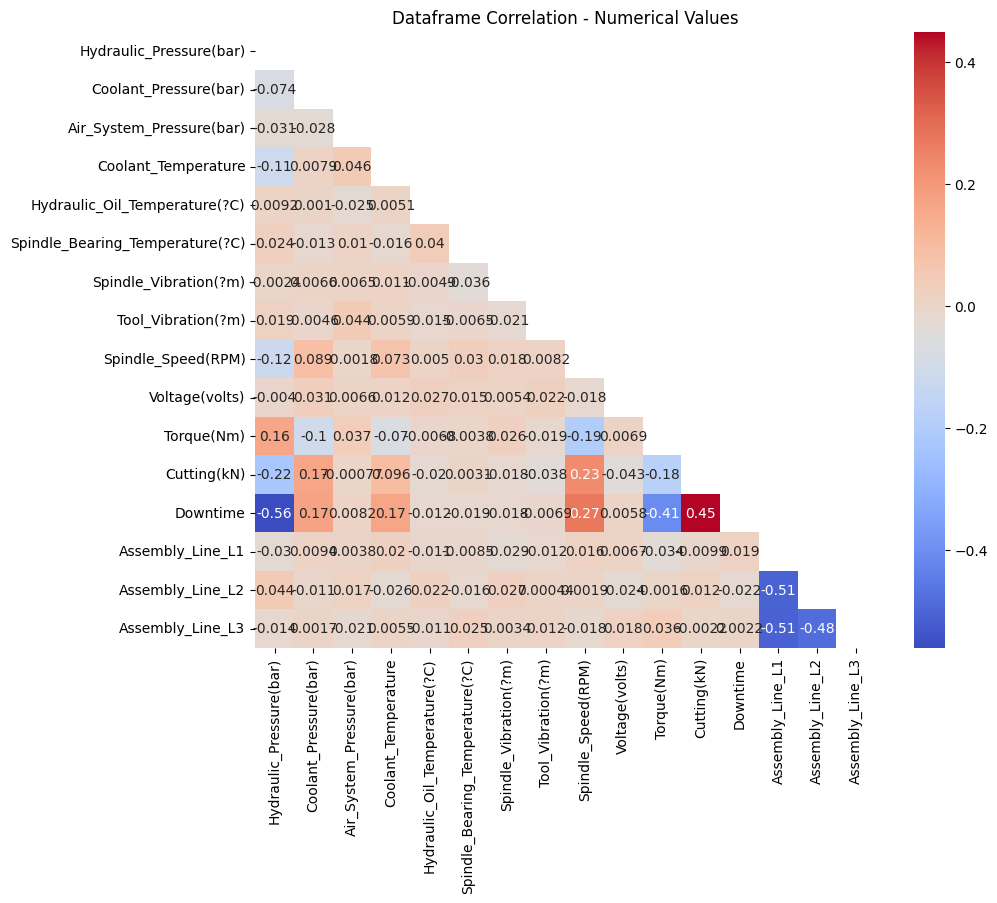

In [170]:
corr = df.select_dtypes(include='number').corr()
mask = np.triu(np.ones_like(corr, dtype=float))

plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm')
plt.title('Dataframe Correlation - Numerical Values')
plt.show()

##**2. Feature Selection**
---

In [171]:
input = df[[col for col in df.columns if col not in ['Date', 'Machine_ID', 'Downtime']]]
dep_var = df['Downtime']

###a. Recursive feature elimination with cross-validation (RFECV)

In [172]:
lr = LogisticRegression()
selector = RFECV(
    estimator=lr,
    step=1,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    #min_features_to_select=5,
    verbose=5,
)
selector.fit(input, dep_var)
print(selector.support_)

Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Fitting estimator with 11 features.
Fitting estimator with 10 features.
[ True  True  True  True False False False  True False False  True  True
 False  True  True]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [173]:
df_to_use = pd.DataFrame({
    'use': selector.support_
}, index = input.columns.tolist())
display(df_to_use)

columns_rfecv = df_to_use[df_to_use['use'] == True].index.tolist()

,use
Hydraulic_Pressure(bar),True
Coolant_Pressure(bar),True
Air_System_Pressure(bar),True
Coolant_Temperature,True
Hydraulic_Oil_Temperature(?C),False
Spindle_Bearing_Temperature(?C),False
Spindle_Vibration(?m),False
Tool_Vibration(?m),True
Spindle_Speed(RPM),False
Voltage(volts),False


###b. Select K-Best

In [174]:
selector = mutual_info_classif(input, dep_var, random_state=42)

score_df = pd.DataFrame({
    'scores': selector.tolist()
}, index=input.columns.tolist()).sort_values(by='scores', ascending=False)
score_df

,scores
Coolant_Pressure(bar),0.650058
Torque(Nm),0.637412
Spindle_Speed(RPM),0.615737
Hydraulic_Pressure(bar),0.501768
Cutting(kN),0.499273
Coolant_Temperature,0.387886
Spindle_Bearing_Temperature(?C),0.018216
Tool_Vibration(?m),0.014096
Voltage(volts),0.004221
Assembly_Line_L2,0.003198


In [175]:
columns_skbest = score_df.index[0:4].tolist()

##**3. Data Splitting**
---

In [176]:
x = df[columns_skbest]#columns_skbest]
y = df['Downtime']

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=42)

In [177]:
columns_skbest

['Coolant_Pressure(bar)',
 'Torque(Nm)',
 'Spindle_Speed(RPM)',
 'Hydraulic_Pressure(bar)']

In [178]:
columns_rfecv

['Hydraulic_Pressure(bar)',
 'Coolant_Pressure(bar)',
 'Air_System_Pressure(bar)',
 'Coolant_Temperature',
 'Tool_Vibration(?m)',
 'Torque(Nm)',
 'Cutting(kN)',
 'Assembly_Line_L2',
 'Assembly_Line_L3']

##**4. Data Scaling**
---

In [179]:
scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

#**Data Modelling**
---

##**1. Classification Model**
---

###a. Logistic Regression

Cross Validation Scores: [0.85142857 0.80857143 0.79714286 0.83667622 0.80229226]
Mean of Cross Validation Scores: 0.8192222677036431

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       370
           1       0.82      0.82      0.82       380

    accuracy                           0.82       750
   macro avg       0.82      0.82      0.82       750
weighted avg       0.82      0.82      0.82       750


Confusion Matrix:


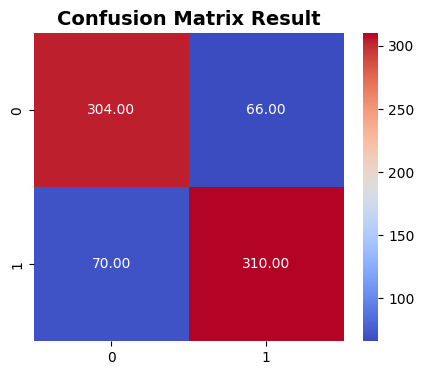

In [180]:
model = LogisticRegression(random_state=42, max_iter=5000)
model.fit(x_train, y_train)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')

print(f'Cross Validation Scores: {cross_val}')
print(f'Mean of Cross Validation Scores: {cross_val.mean()}\n')

y_pred = model.predict(x_test)
print(f'Classification Report:\n{classification_report(y_test, y_pred)}')

cm = confusion_matrix(y_test, y_pred)
print(f'\nConfusion Matrix:')
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Confusion Matrix Result', fontsize=14, fontweight='bold')
plt.show()

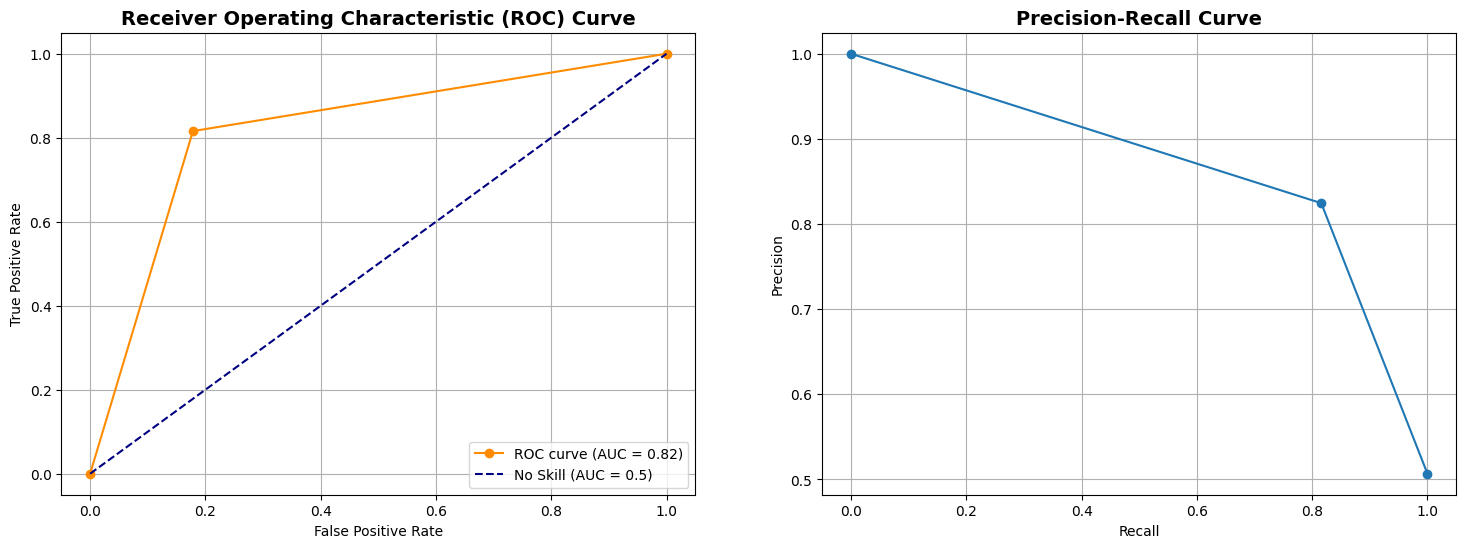

In [181]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
precision, recall, threshold = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', marker='o', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='No Skill (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.grid(True)
plt.show()

###b. SVC - Support Vector Classifier

Cross Validation Scores: [0.64857143 0.61714286 0.58571429 0.66189112 0.64756447]
Mean of Cross Validation Scores: 0.6321768317642243

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.95      0.72       370
           1       0.87      0.33      0.48       380

    accuracy                           0.63       750
   macro avg       0.73      0.64      0.60       750
weighted avg       0.73      0.63      0.60       750


Confusion Matrix:


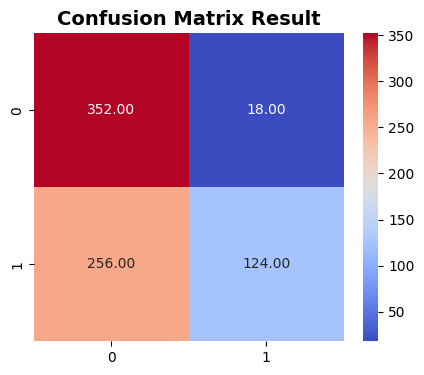

In [182]:
model = SVC(kernel='rbf', random_state=42)
model.fit(x_train, y_train)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val = cross_val_score(model, x_train, y_train, cv=kfold, scoring='accuracy')

print(f'Cross Validation Scores: {cross_val}')
print(f'Mean of Cross Validation Scores: {cross_val.mean()}\n')

y_pred = model.predict(x_test)
print(f'Classification Report:\n{classification_report(y_test, y_pred)}')

cm = confusion_matrix(y_test, y_pred)
print(f'\nConfusion Matrix:')
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Confusion Matrix Result', fontsize=14, fontweight='bold')
plt.show()

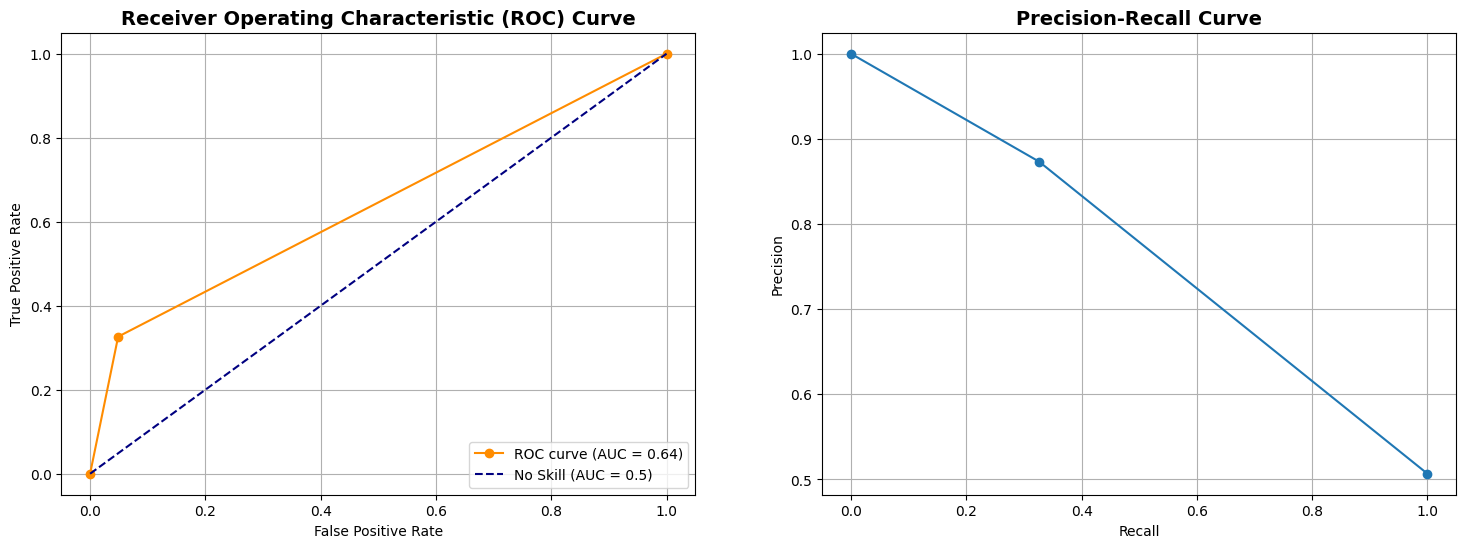

In [183]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
precision, recall, threshold = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', marker='o', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='No Skill (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.grid(True)
plt.show()

###c. XGBoost

Cross Validation Scores: [0.97428571 0.99428571 0.96857143 0.97707736 0.97994269]
Mean of Cross Validation Scores: 0.9788325828898895

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       370
           1       0.98      0.98      0.98       380

    accuracy                           0.98       750
   macro avg       0.98      0.98      0.98       750
weighted avg       0.98      0.98      0.98       750


Confusion Matrix:


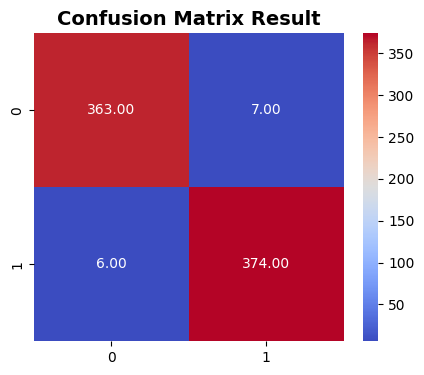

In [184]:
model_xgb = XGBClassifier(random_state=42, learning_rate=0.01)
model_xgb.fit(x_train, y_train)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val = cross_val_score(model_xgb, x_train, y_train, cv=kfold, scoring='accuracy')

print(f'Cross Validation Scores: {cross_val}')
print(f'Mean of Cross Validation Scores: {cross_val.mean()}\n')

y_pred = model_xgb.predict(x_test)
print(f'Classification Report:\n{classification_report(y_test, y_pred)}')

cm = confusion_matrix(y_test, y_pred)
print(f'\nConfusion Matrix:')
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Confusion Matrix Result', fontsize=14, fontweight='bold')
plt.show()

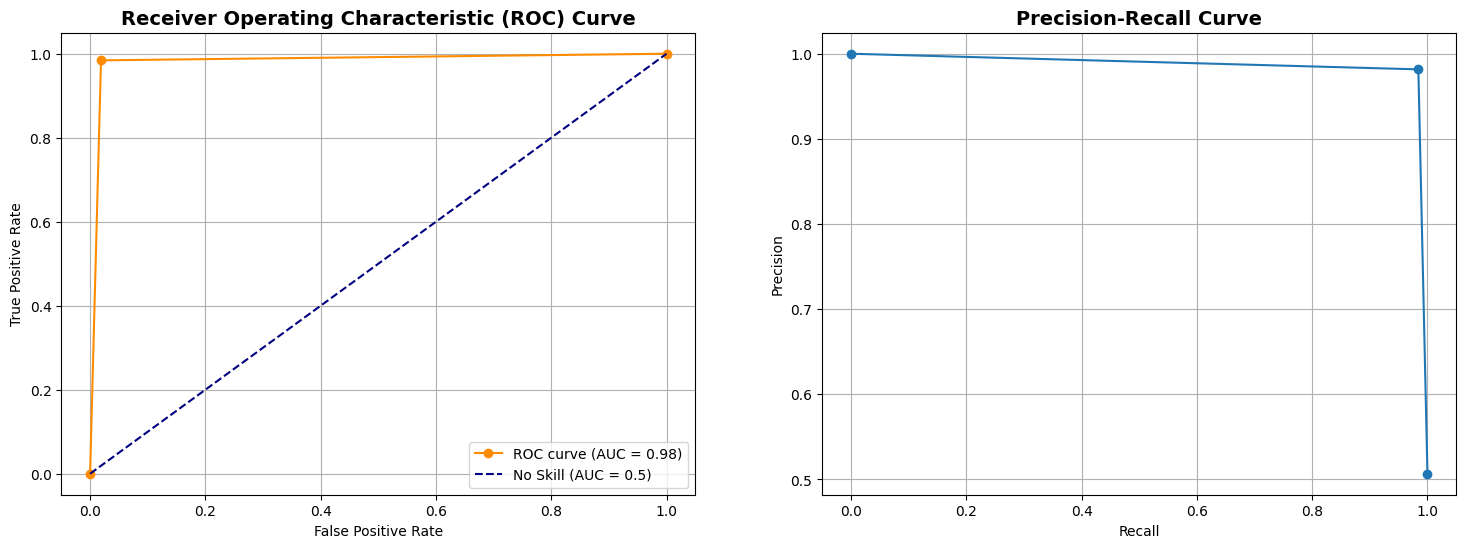

In [185]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
precision, recall, threshold = precision_recall_curve(y_test, y_pred)

plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', marker='o', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='No Skill (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.grid(True)
plt.show()

##**2. Data Clustering**
---

###a. Feature Selection

In [186]:
df_fs = df[[col for col in df.columns if col not in ['Date', 'Machine_ID', 'Downtime']]]

####Variance Threshold

In [187]:
scaler = MinMaxScaler()
df_fs_scaled = scaler.fit_transform(df_fs)

vt = VarianceThreshold(threshold=0.01)
x_variance = vt.fit_transform(df_fs_scaled)

result_vt = pd.DataFrame({
    'result': vt.get_support().tolist()
}, index=df_fs.columns)
result_vt

,result
Hydraulic_Pressure(bar),True
Coolant_Pressure(bar),False
Air_System_Pressure(bar),True
Coolant_Temperature,False
Hydraulic_Oil_Temperature(?C),True
Spindle_Bearing_Temperature(?C),True
Spindle_Vibration(?m),True
Tool_Vibration(?m),True
Spindle_Speed(RPM),True
Voltage(volts),True


####MCFS

In [188]:
mcfs = MCFS.mcfs(df_fs.values, n_selected_features=5, k=5)

result_mcfs = pd.DataFrame({
    'result_score': mcfs.tolist()
}, index=df_fs.columns).sort_values(by='result_score', ascending=False)
result_mcfs

,result_score
Coolant_Pressure(bar),14
Assembly_Line_L3,13
Assembly_Line_L2,12
Air_System_Pressure(bar),11
Coolant_Temperature,10
Cutting(kN),9
Assembly_Line_L1,8
Hydraulic_Pressure(bar),7
Hydraulic_Oil_Temperature(?C),6
Spindle_Bearing_Temperature(?C),5


In [189]:
cols = result_mcfs.head(5).index.tolist()
input_new = df[cols]

# In this case, scaling is not used as the clustering algorthm performed worse with scaling
#scaler = StandardScaler()
#input_new = scaler.fit_transform(input_new)

###b. Clustering with KMeans

In [190]:
n_clusters = range(2, 10)

sil_score, inertia = [], []
for cluster in n_clusters:
  kmeans = KMeans(n_clusters=cluster, random_state=42)
  kmeans.fit(input_new)
  label = kmeans.labels_

  inertia.append(kmeans.inertia_)
  sil_score.append(silhouette_score(input_new, label, metric='euclidean'))

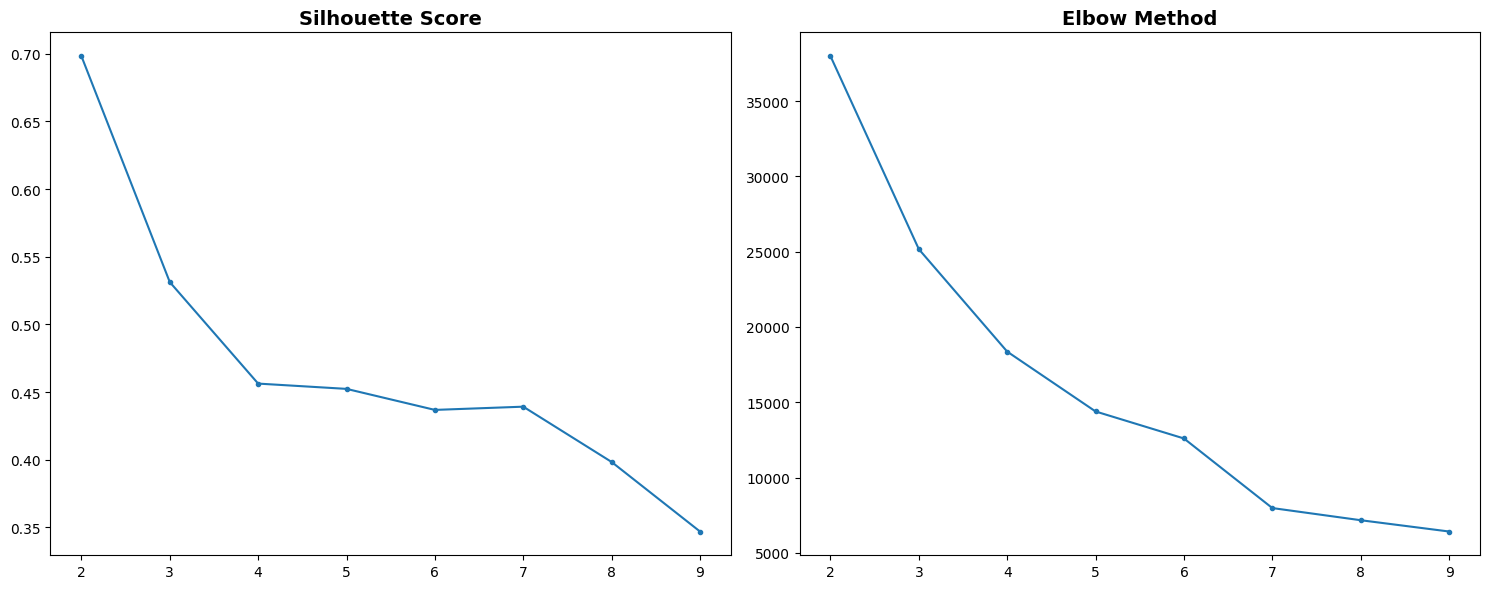

In [191]:
data_result = pd.DataFrame({
    'Silhouette Score': sil_score,
    'Elbow Method': inertia
}, index=n_clusters)

plt.figure(figsize=(15, 6))
for i, col in enumerate(data_result.columns):
  plt.subplot(1, 2, i+1)
  plt.plot(data_result.index.tolist(), data_result[col], marker='.')
  plt.title(col, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [192]:
kmeans = KMeans(n_clusters=5, random_state=42, max_iter=5000)
kmeans.fit(input_new)
label = kmeans.labels_

silhouette = silhouette_score(input_new, label, metric='euclidean')
print(f'Silhouette Score: {silhouette}')

df_new = df.copy()
df_new['cluster'] = kmeans.predict(input_new)
input_new['cluster'] = kmeans.predict(input_new)
cluster_data = df_new.groupby(by='cluster').agg({
    'Coolant_Pressure(bar)': 'mean',
    'Assembly_Line_L3': 'mean',
    'Assembly_Line_L2': 'mean',
    'Air_System_Pressure(bar)': 'mean',
    'Coolant_Temperature': 'mean',
    'Downtime': 'mean'
})

display(df_new['cluster'].value_counts())
display(cluster_data)

Silhouette Score: 0.4523452574842698


/tmp/ipython-input-4058875724.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  input_new['cluster'] = kmeans.predict(input_new)


,count
cluster,
4,705
3,512
0,501
2,487
1,293


,Coolant_Pressure(bar),Assembly_Line_L3,Assembly_Line_L2,Air_System_Pressure(bar),Coolant_Temperature,Downtime
cluster,,,,,,
0,4.962629,0.301397,0.319361,6.490536,11.953094,0.504990
1,5.126799,0.361775,0.310580,6.551007,30.342662,0.788396
2,4.852936,0.310062,0.338809,6.499983,20.894045,0.365503
3,4.979848,0.343750,0.353516,6.473125,6.654297,0.398438
4,4.901482,0.330496,0.297872,6.503964,25.467518,0.565957


##**3. Clustering Results**
---

###a. Data Distribution per Cluster (Based on selected features)

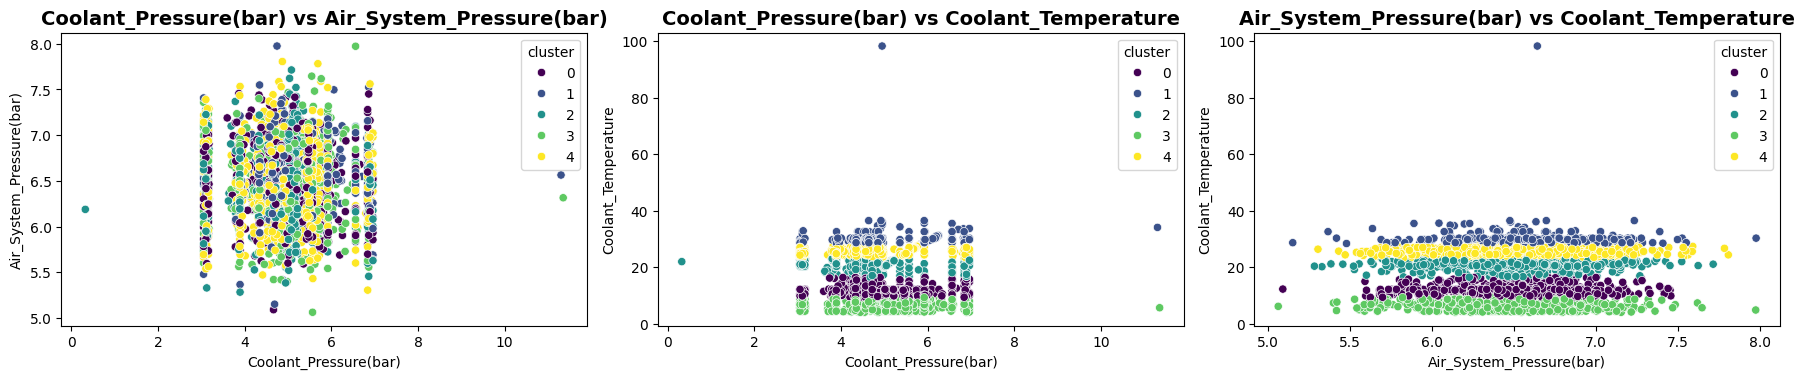

In [193]:
cols_used = ['cluster', 'Assembly_Line_L2', 'Assembly_Line_L3']
columns = [col for col in input_new.columns if col not in cols_used]
iter=0

plt.figure(figsize=(18, 14))
for col in columns:
  cols = [column for column in input_new.columns if column not in cols_used and column != col]
  for column in cols:
    plt.subplot(4, 3, iter+1)
    sns.scatterplot(x=input_new[col], y=input_new[column], hue=input_new['cluster'], palette='viridis')
    plt.title(f'{col} vs {column}', fontsize=14, fontweight='bold')
    iter+=1
  cols_used.append(col)
plt.tight_layout()
plt.show()

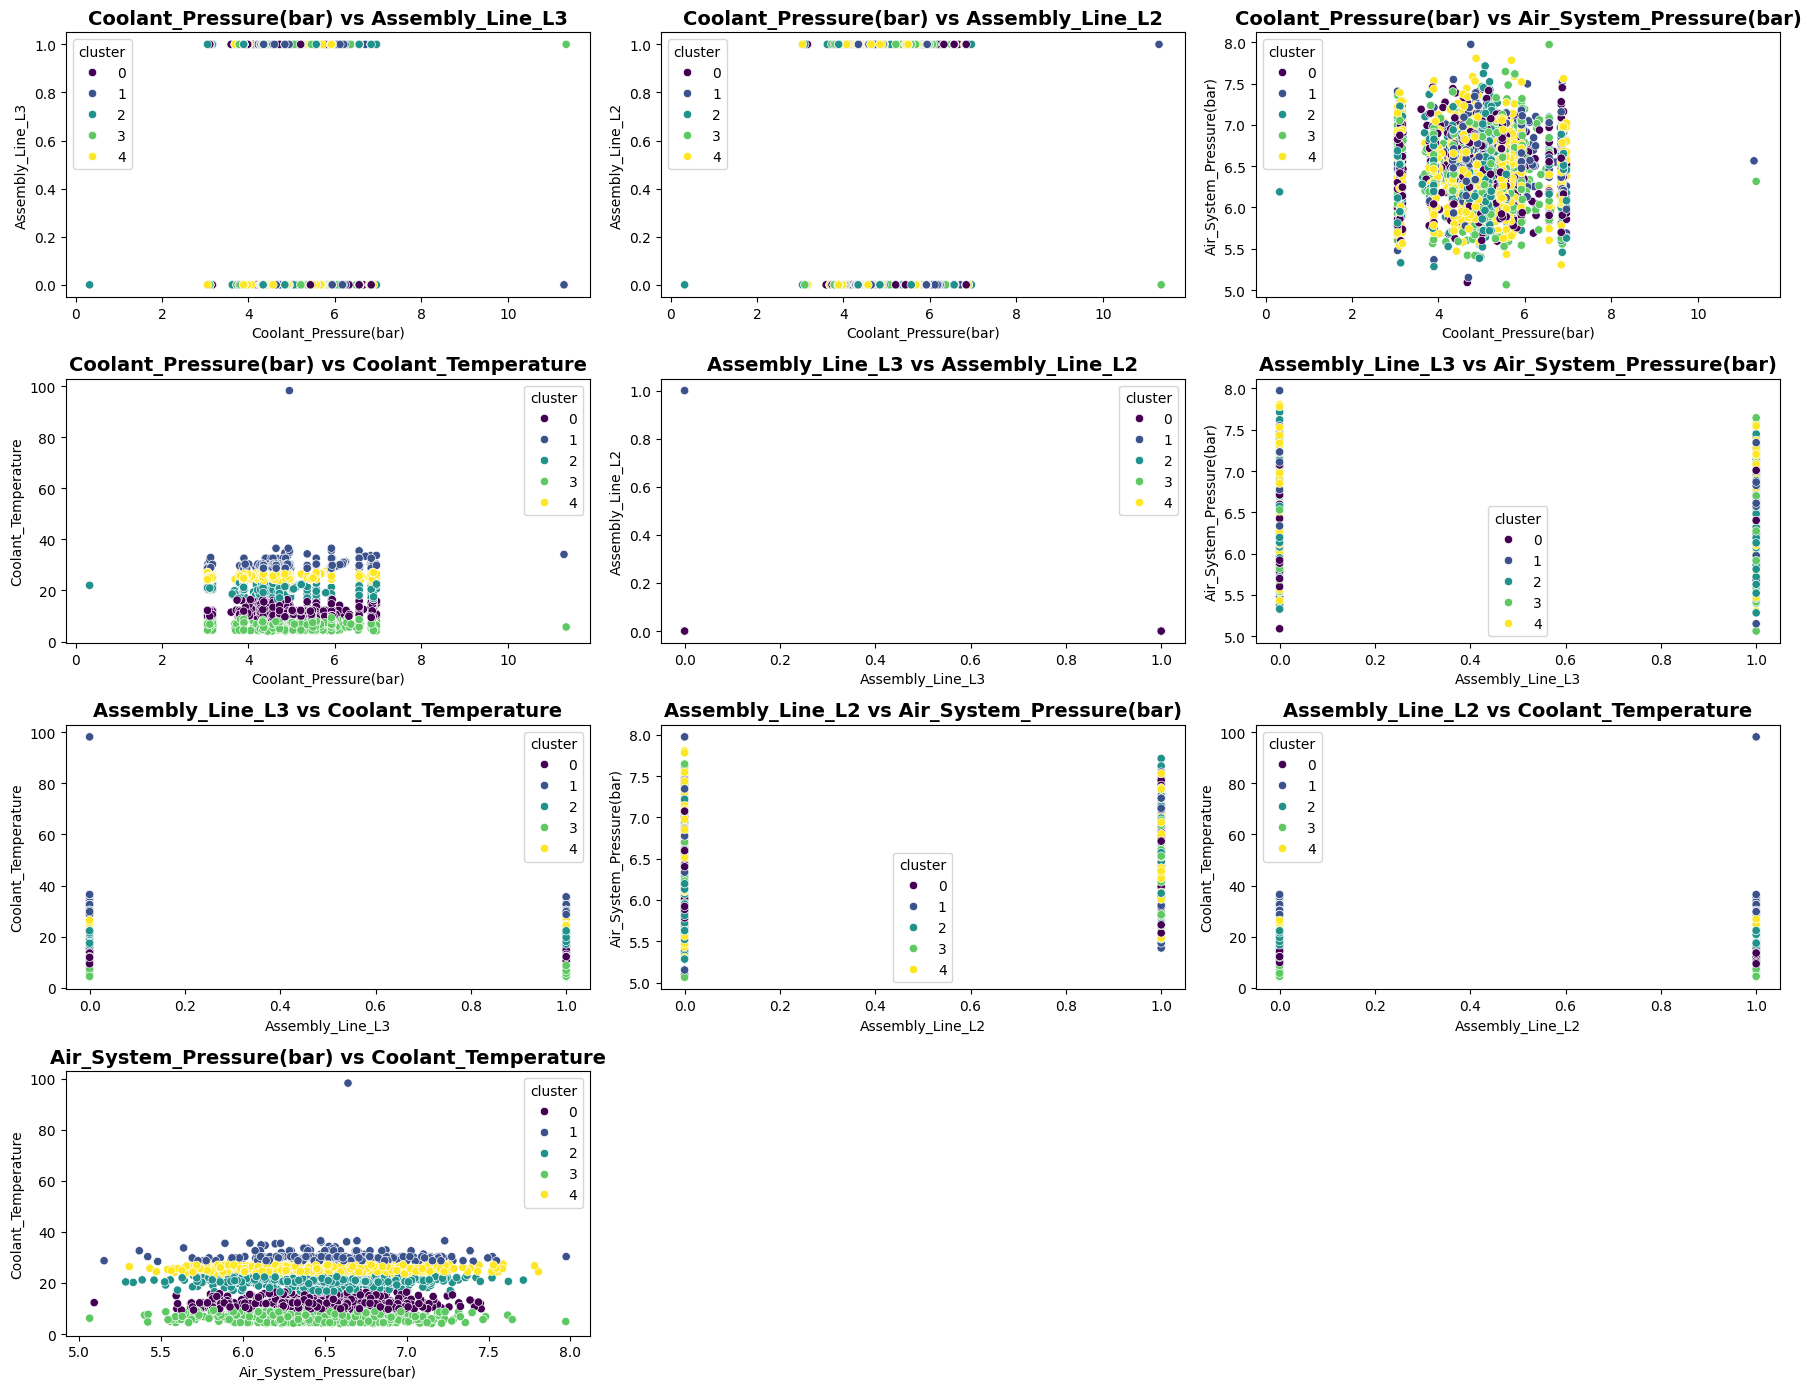

In [194]:
cols_used = ['cluster']
columns = [col for col in input_new.columns if col not in cols_used]
iter=0

plt.figure(figsize=(18, 14))
for col in columns:
  cols = [column for column in input_new.columns if column not in cols_used and column != col]
  for column in cols:
    plt.subplot(4, 3, iter+1)
    sns.scatterplot(x=input_new[col], y=input_new[column], hue=input_new['cluster'], palette='viridis')
    plt.title(f'{col} vs {column}', fontsize=14, fontweight='bold')
    iter+=1
  cols_used.append(col)
plt.tight_layout()
plt.show()

###b. Categorical Data Across Clusters

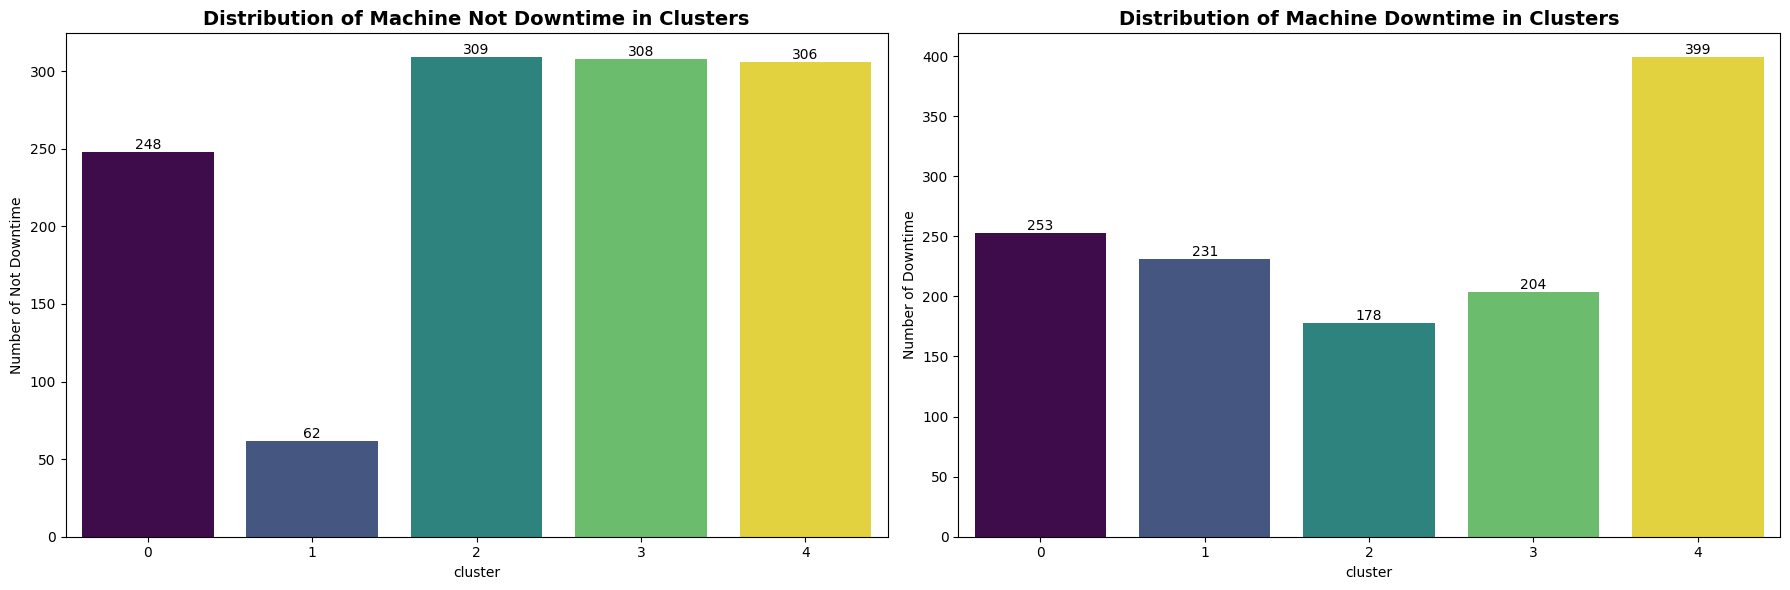

In [195]:
df_pvt = df_new.pivot_table(columns='Downtime', index='cluster', values='Date', aggfunc='count')

plt.figure(figsize=(18, 6))
for i, col in enumerate(df_pvt.columns):
  plt.subplot(1, 2, i+1)
  ax = sns.barplot(x=df_pvt.index, y=df_pvt[col], hue=df_pvt.index, palette='viridis', legend=False)
  for val in ax.containers:
    label=[v.get_height() for v in val]
    ax.bar_label(val, label=label, label_type='edge')
  down = 'Downtime' if col==1 else 'Not Downtime'
  plt.ylabel(f'Number of {down}')
  plt.title(f'Distribution of Machine {down} in Clusters', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

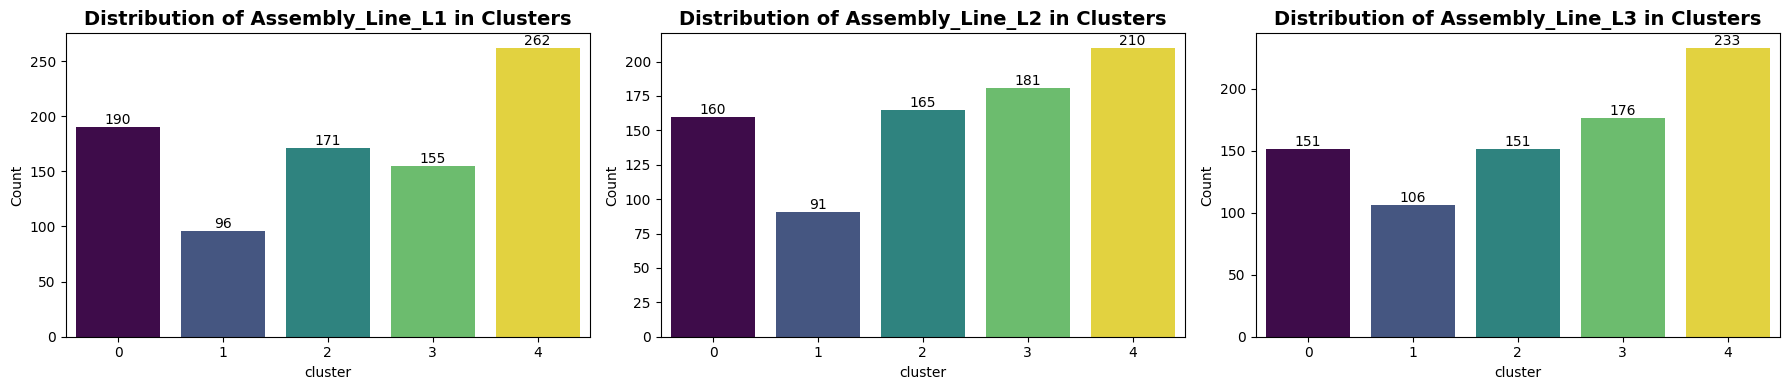

In [196]:
df_assembly_line = df_new.groupby(by='cluster').agg({
    'Assembly_Line_L1':'sum',
    'Assembly_Line_L2':'sum',
    'Assembly_Line_L3':'sum'
})

plt.figure(figsize=(18, 4))
for i, col in enumerate(df_assembly_line.columns):
  plt.subplot(1, 3, i+1)
  ax = sns.barplot(x=df_assembly_line.index, y=df_assembly_line[col], hue=df_assembly_line.index, palette='viridis', legend=False)
  for val in ax.containers:
    label=[v.get_height() for v in val]
    ax.bar_label(val, label=label, label_type='edge')
  plt.ylabel('Count')
  plt.title(f'Distribution of {col} in Clusters', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

###c. Numerical Data Distribution

In [197]:
cols_float = df_new.select_dtypes(include=['float']).columns.tolist()
cols_float.append('cluster')

flt_agg = df_new[cols_float].groupby(by='cluster').mean()
flt_agg

,Hydraulic_Pressure(bar),Coolant_Pressure(bar),Air_System_Pressure(bar),Coolant_Temperature,Hydraulic_Oil_Temperature(?C),Spindle_Bearing_Temperature(?C),Spindle_Vibration(?m),Tool_Vibration(?m),Spindle_Speed(RPM),Voltage(volts),Torque(Nm),Cutting(kN)
cluster,,,,,,,,,,,,
0,102.156871,4.962629,6.490536,11.953094,47.739450,35.108706,0.983921,24.786836,19964.307385,347.892216,25.098387,2.799780
1,89.945629,5.126799,6.551007,30.342662,47.651987,34.786348,1.021377,25.441579,21221.563140,350.102379,23.552205,3.011647
2,106.817369,4.852936,6.499983,20.894045,47.437676,35.258648,1.013236,25.684823,19649.774294,352.815189,26.536389,2.621956
3,105.519049,4.979848,6.473125,6.654297,47.553673,35.028682,1.023498,25.760410,20221.283203,348.080073,25.790368,2.721021
4,99.056618,4.901482,6.503964,25.467518,47.682173,35.030671,1.010622,25.425836,20573.939007,347.351761,24.721904,2.830695


In [198]:
df['Machine_ID'].unique()

array(['Makino-L1-Unit1-2013', 'Makino-L3-Unit1-2015',
       'Makino-L2-Unit1-2015'], dtype=object)

#**Conclusion**
---
The classification model that was created is able to predict whether or not a machine would fail fairly reliably, with an accuracy of higher than 80%. Based on the results however, it is concluded that the XGBoost model would be the most ideal for use.

The results of this project shows that there are many factors that contributed to the failure of a machine, which is ascertained by the results of feature selection, which shows the significance of a feature with regards to it's impact on machine failure. Some of the top factors include:
1. **Hydraulic Pressure** - lower pressures tend to indicate and/or cause failure
2. **Torque** - lower torque may indicate/cause machine failure
3. **Coolant Temperature** - higher coolant temperatures tend to indicate and/or cause machine failure
4. **Spindle Speed** - higher spindle speeds tend to indicate and/or cause machine failure

At the same time, the number of failures peaked at around mid-April 2022, suggesting that at the time, the use of the machines peaked, causing less maintenance and increased wear, which would cause more failures.

Results of clustering on this project has yielded 5 clusters:
1. **Cluster 0**: This cluster is comprised of observations of machines that operated **with a relatively high amount of experienced downtime**, as shown by the slightly higher number of downtime. Compared to other clusters, machines of this cluster **has a lower coolant temperature with a short range of air system pressure (~5.5-7.5)**. This suggests that observations of this cluster ***shows a fairly low performance and not particularly reliable***.
2. **Cluster 1**: Observations of machines of this cluster shows **the highest downtime rate**. At the same time, machines of this cluster has **the highest coolant temperature and the highest average spindle speed**. As such, machines of this cluster has ***decent performance, but relatively high reliability, likely due to wear and tear***.
3. **Cluster 2**: This cluster has the **highest uptime rate** compared to other clusters. Observations of machines of this cluster has **medium coolant temperature and the lowest average spindle speed**. This suggests that machines of this cluster are ***of decent performance and has high reliability***.
4. **Cluster 3**: This cluster has **the second highest uptime rate**. At the same time, observations of machines of this cluster has **lowest coolant temperature and relatively high average spindle speed**. As such, observations of machines of this cluster ***has good performance and is highly reliable***.
5. **Cluster 4**: This cluster has an **almost 50/50 downtime rate**, as shown by the almost equal distribution of downtime and non downtime observations. Observations of machines of this cluster has **the lowest average spindle speed, but relatively high coolant temperature**. This suggests that observations of machines of this cluster are ***of mediocre performance and has low reliability***.

Based on these results, it could be concluded that a machine that performs better and more reliable tend to have charasteristics that is found on Cluster 2 and Cluster 3. These charasteristics include lower coolant temperature and relatively low-to-medium spindle speeds. This situation (lower stress for machines) may explain why observations of these two clusters yields higher reliability.

On the other hand, observations of Cluster 1 and 4 yielded low reliability, which is likely caused by more severe stress or prolonged use without maintenance. This is due to the fact that observations of these clusters show high coolant temperatures and average spindle speeds.

Lastly, observations of Cluster 0 shows observations with relatively mediocre performance and low reliability, despite the relatively low amount of stress or strain experienced. This may be due to the fact that the machines are broken or are operating in a reduced capacity.

In conclusion, based on the results of feature selection and clustering, it could be said that machines that would experience downtimes tend to be machines that has experienced prolonged use (like in months March and April), or has been used in such a way that its coolant temperature and spindle speeds are high, whilst their hydraulic pressire and torque are low. As such, machines that would begin experiencing such symptomps should be monitored and watched closely in order to prepare it for maintenance or downtime.

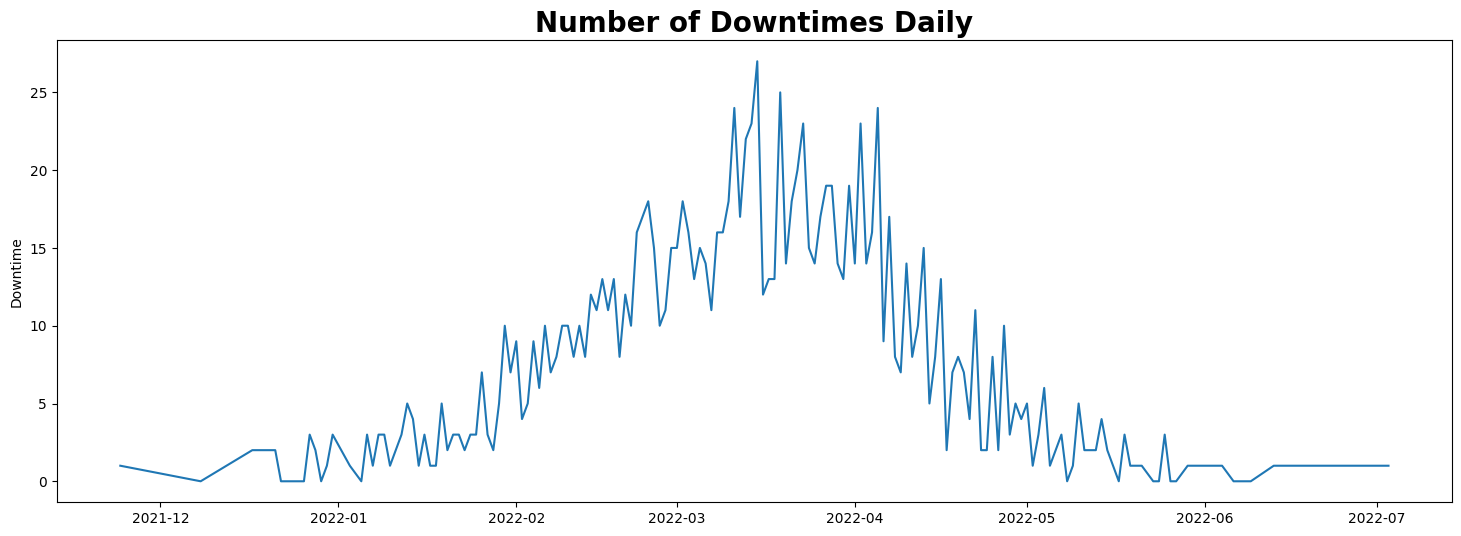

In [199]:
df_daily = df.groupby(by='Date').agg({
    'Downtime': 'sum'
})

plt.figure(figsize=(18,6))
sns.lineplot(x=df_daily.index.tolist(), y=df_daily['Downtime'], markers='o')
plt.title('Number of Downtimes Daily', fontsize=20, fontweight='bold')
plt.show()